In [33]:
!pip install pandas numpy matplotlib seaborn scipy statannotations missingno scikit-posthocs tabulate

  Using cached tabulate-0.9.0-py3-none-any.whl.metadata (34 kB)
Using cached tabulate-0.9.0-py3-none-any.whl (35 kB)


In [2]:
import pandas as pd
import glob
import os

# Define the path to the data folder
# Use '.' since the notebook is inside the joined_data folder
data_folder = '.'

# Use glob to find all CSV files in the folder
# Construct the pattern correctly for the current directory
glob_pattern = os.path.join(data_folder, '*.csv')
print(f"Looking for files matching pattern: {glob_pattern}") # Debug print
csv_files = glob.glob(glob_pattern)

# Check if any CSV files were found
if not csv_files:
    print(f"No CSV files found in the directory: {os.path.abspath(data_folder)}") # Print absolute path for clarity
else:
    print(f"Found {len(csv_files)} CSV files:")
    # Filter out the notebook file itself if it ends with .csv (unlikely but safe)
    csv_files = [f for f in csv_files if not f.endswith('.ipynb')] # Ensure we only grab CSVs
    for f in csv_files:
        print(f" - {os.path.basename(f)}")

    # List to hold dataframes
    df_list = []

    # Load each CSV file and append to the list
    for file in csv_files:
        # Construct the full path for reading, although relative should work if glob found it
        file_path = os.path.join(data_folder, file)
        try:
            # Attempt to load the CSV
            df_temp = pd.read_csv(file_path, low_memory=False)
            # Add a column to identify the source file
            df_temp['source_file'] = os.path.basename(file)
            df_list.append(df_temp)
            print(f"Successfully loaded {os.path.basename(file)}")
        except Exception as e:
            print(f"Could not load file {os.path.basename(file)}: {e}")

    # Concatenate all dataframes in the list
    if df_list:
        df_combined = pd.concat(df_list, ignore_index=True)
        print(f"\nSuccessfully concatenated {len(df_list)} files into a single DataFrame.")
        print(f"Total rows: {len(df_combined)}, Total columns: {len(df_combined.columns)}")

        # --- Data Quality Assessment ---
        print("\n--- Initial Data Quality Assessment ---")

        # 1. Display basic info (non-null counts, data types)
        print("\n1. DataFrame Info:")
        # Increase max_rows display for info if needed
        # with pd.option_context('display.max_rows', None):
        df_combined.info(verbose=True, show_counts=True)


        # 2. Check for missing values per column
        print("\n2. Missing Values per Column:")
        missing_values = df_combined.isnull().sum()
        missing_values = missing_values[missing_values > 0] # Show only columns with missing values
        if not missing_values.empty:
            print(missing_values)
            print(f"Total missing values: {df_combined.isnull().sum().sum()}")
        else:
            print("No missing values found.")

        # 3. Show descriptive statistics for numerical and categorical columns
        print("\n3. Descriptive Statistics:")
        # For numerical columns
        print("\n   Numerical Features:")
        # Increase display precision if needed
        # with pd.option_context('display.precision', 3):
        print(df_combined.describe(include='number'))
        # For object/categorical columns (includes things like top frequency)
        print("\n   Categorical/Object Features:")
        print(df_combined.describe(include='object'))


        # 4. Check data types (already covered by info(), but can list explicitly)
        # print("\n4. Data Types:") # Redundant with info()
        # print(df_combined.dtypes)

        # 5. Check for duplicate rows
        print("\n5. Duplicate Rows:")
        num_duplicates = df_combined.duplicated().sum()
        if num_duplicates > 0:
            print(f"Found {num_duplicates} duplicate rows.")
        else:
            print("No duplicate rows found.")

        # 6. Unique values in 'source_file' column (verification)
        print("\n6. Source Files Loaded:")
        print(df_combined['source_file'].unique())

    else:
        print("\nNo dataframes were loaded, cannot perform quality assessment.")


Looking for files matching pattern: .\*.csv
Found 8 CSV files:
 - T01_Mara.csv
 - T02_Laura.csv
 - T03_Nancy.csv
 - T04_Michelle.csv
 - T05_Felicitas.csv
 - T06_Mara_Selena.csv
 - T07_Geraldinn.csv
 - T08_Karina.csv
Successfully loaded T01_Mara.csv
Successfully loaded T02_Laura.csv
Successfully loaded T03_Nancy.csv
Successfully loaded T04_Michelle.csv
Successfully loaded T05_Felicitas.csv
Successfully loaded T06_Mara_Selena.csv
Successfully loaded T07_Geraldinn.csv
Successfully loaded T08_Karina.csv

Successfully concatenated 8 files into a single DataFrame.
Total rows: 1567879, Total columns: 17

--- Initial Data Quality Assessment ---

1. DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567879 entries, 0 to 1567878
Data columns (total 17 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   Sol                           1567879 non-null  int64  
 1   user                          1567

In [3]:
# Make a copy to preserve the original dataframe if needed
df_clean = df_combined.copy()

print(f"Original shape: {df_clean.shape}")

# --- Step 1: Remove Duplicate Rows ---
initial_rows = len(df_clean)
df_clean.drop_duplicates(inplace=True)
rows_after_duplicates = len(df_clean)
print(f"Removed {initial_rows - rows_after_duplicates} duplicate rows.")
print(f"Shape after removing duplicates: {df_clean.shape}")

# --- Step 2: Drop Uninformative/Redundant Columns ---
columns_to_drop = ['energy_mifflin_keytel [watt]', 'temperature [NA]', 'sleep_position [NA]']
# Check if columns exist before dropping
columns_exist = [col for col in columns_to_drop if col in df_clean.columns]
if columns_exist:
    df_clean.drop(columns=columns_exist, inplace=True)
    print(f"Dropped columns: {columns_exist}")
    print(f"Shape after dropping columns: {df_clean.shape}")
else:
    print("Columns to drop not found or already removed.")


# --- Step 3: Filter Invalid Physiological Data ---
initial_rows = len(df_clean)

# Define plausible ranges
spo2_min = 70
systolic_min = 1 # Assuming 0 is invalid
temp_min = 25
temp_max = 45

# Apply filters - using .loc ensures we modify the DataFrame correctly
if 'SPO2 [%]' in df_clean.columns:
    df_clean = df_clean.loc[df_clean['SPO2 [%]'].isnull() | (df_clean['SPO2 [%]'] >= spo2_min)]
    print(f"Rows remaining after SPO2 filter (>={spo2_min}% or NaN): {len(df_clean)}")

if 'systolic_pressure [mmHg]' in df_clean.columns:
    df_clean = df_clean.loc[df_clean['systolic_pressure [mmHg]'].isnull() | (df_clean['systolic_pressure [mmHg]'] > systolic_min)]
    print(f"Rows remaining after Systolic Pressure filter (>{systolic_min} mmHg or NaN): {len(df_clean)}")

if 'temperature_celcius [C]' in df_clean.columns:
    df_clean = df_clean.loc[df_clean['temperature_celcius [C]'].isnull() | ((df_clean['temperature_celcius [C]'] >= temp_min) & (df_clean['temperature_celcius [C]'] <= temp_max))]
    print(f"Rows remaining after Temperature filter ({temp_min}-{temp_max} C or NaN): {len(df_clean)}")

rows_after_filtering = len(df_clean)
print(f"Removed {initial_rows - rows_after_filtering} rows due to invalid physiological values.")
print(f"Final shape after cleaning: {df_clean.shape}")

# --- Step 4: Re-assess Data Quality ---
print("\n--- Data Quality Assessment After Initial Cleaning ---")

# 1. Display basic info
print("\n1. DataFrame Info:")
df_clean.info(verbose=True, show_counts=True)

# 2. Check for missing values per column
print("\n2. Missing Values per Column:")
missing_values_clean = df_clean.isnull().sum()
missing_values_clean = missing_values_clean[missing_values_clean > 0]
if not missing_values_clean.empty:
    print(missing_values_clean)
    print(f"Total missing values: {df_clean.isnull().sum().sum()}")
else:
    print("No missing values found.")

# 3. Show descriptive statistics
print("\n3. Descriptive Statistics:")
print("\n   Numerical Features:")
print(df_clean.describe(include='number'))
print("\n   Categorical/Object Features:")
print(df_clean.describe(include='object'))

# Note: Further steps might involve deciding how to handle the remaining missing values
# (e.g., imputation, dropping rows/columns based on analysis needs)
# or converting time columns to datetime objects.

Original shape: (1567879, 17)
Removed 12246 duplicate rows.
Shape after removing duplicates: (1555633, 17)
Dropped columns: ['energy_mifflin_keytel [watt]', 'temperature [NA]', 'sleep_position [NA]']
Shape after dropping columns: (1555633, 14)
Rows remaining after SPO2 filter (>=70% or NaN): 1547049
Rows remaining after Systolic Pressure filter (>1 mmHg or NaN): 1547039
Rows remaining after Temperature filter (25-45 C or NaN): 1467753
Removed 87880 rows due to invalid physiological values.
Final shape after cleaning: (1467753, 14)

--- Data Quality Assessment After Initial Cleaning ---

1. DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 1467753 entries, 0 to 1567878
Data columns (total 14 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   Sol                          1467753 non-null  int64  
 1   user                         1467753 non-null  object 
 2   source_file                  14677

In [7]:
import pandas as pd
import numpy as np # Needed for correlation calculation on boolean matrix

# --- Initial Cleaning Steps (as before) ---

# Make a copy to preserve the original dataframe if needed
# Assuming df_combined exists from the previous cell
df_clean = df_combined.copy()

print(f"Original shape: {df_clean.shape}")

# Step 1: Remove Duplicate Rows
initial_rows = len(df_clean)
df_clean.drop_duplicates(inplace=True)
rows_after_duplicates = len(df_clean)
print(f"Removed {initial_rows - rows_after_duplicates} duplicate rows.")
print(f"Shape after removing duplicates: {df_clean.shape}")

# Step 2: Drop Uninformative/Redundant Columns
columns_to_drop = ['energy_mifflin_keytel [watt]', 'temperature [NA]', 'sleep_position [NA]']
columns_exist = [col for col in columns_to_drop if col in df_clean.columns]
if columns_exist:
    df_clean.drop(columns=columns_exist, inplace=True)
    print(f"Dropped columns: {columns_exist}")
    print(f"Shape after dropping columns: {df_clean.shape}")
else:
    print("Columns to drop not found or already removed.")

# Step 3: Filter Invalid Physiological Data
initial_rows = len(df_clean)
spo2_min = 70
systolic_min = 1
temp_min = 25
temp_max = 45

if 'SPO2 [%]' in df_clean.columns:
    df_clean = df_clean.loc[df_clean['SPO2 [%]'].isnull() | (df_clean['SPO2 [%]'] >= spo2_min)]
if 'systolic_pressure [mmHg]' in df_clean.columns:
    df_clean = df_clean.loc[df_clean['systolic_pressure [mmHg]'].isnull() | (df_clean['systolic_pressure [mmHg]'] > systolic_min)]
if 'temperature_celcius [C]' in df_clean.columns:
    df_clean = df_clean.loc[df_clean['temperature_celcius [C]'].isnull() | ((df_clean['temperature_celcius [C]'] >= temp_min) & (df_clean['temperature_celcius [C]'] <= temp_max))]

rows_after_filtering = len(df_clean)
print(f"Removed {initial_rows - rows_after_filtering} rows due to invalid physiological values based on defined ranges.")
print(f"Shape after filtering invalid values: {df_clean.shape}")

# --- Step 4: Handle Time Column ---
time_col = 'time [s/1000]'
datetime_col = 'datetime' # Name for the new datetime column

if time_col in df_clean.columns:
    print(f"\n--- Processing Time Column: {time_col} ---")
    # Convert to numeric, coercing errors (like non-numeric entries) to NaN
    df_clean[time_col] = pd.to_numeric(df_clean[time_col], errors='coerce')

    # Count missing/invalid time values *before* converting to datetime
    invalid_time_count = df_clean[time_col].isnull().sum()

    # Drop rows where the time column is NaN (either originally or after coercion)
    initial_rows = len(df_clean)
    df_clean.dropna(subset=[time_col], inplace=True)
    print(f"Removed {initial_rows - len(df_clean)} rows with invalid/missing values in {time_col}.")
    print(f"Shape after removing rows with missing time: {df_clean.shape}")


    # Convert milliseconds to datetime objects
    try:
        # Create the new datetime column
        df_clean[datetime_col] = pd.to_datetime(df_clean[time_col], unit='ms')
        print(f"Successfully converted {time_col} to '{datetime_col}' objects.")
        # Display time range
        if not df_clean[datetime_col].empty:
             print(f"Time range: {df_clean[datetime_col].min()} to {df_clean[datetime_col].max()}")
        else:
             print("Datetime column is empty after processing.")

        # Optional: Drop the original time column if no longer needed
        # df_clean.drop(columns=[time_col], inplace=True)
        # print(f"Dropped original time column: {time_col}")

    except Exception as e:
        print(f"Could not convert {time_col} to datetime: {e}")
else:
    print(f"\nColumn '{time_col}' not found or DataFrame is empty.")

# --- Step 5: Numerical Summaries of Missing Data (Post-Cleaning) ---
print("\n--- Missing Data Summary (After Cleaning & Time Processing) ---")

if not df_clean.empty:
    # Calculate missing counts and percentages
    missing_counts = df_clean.isnull().sum()
    missing_percentage = (missing_counts / len(df_clean)) * 100
    missing_summary = pd.DataFrame({
        'Missing Count': missing_counts,
        'Missing Percentage (%)': missing_percentage
    })
    # Filter to show only columns with missing data
    missing_summary = missing_summary[missing_summary['Missing Count'] > 0]
    # Sort by percentage descending
    missing_summary.sort_values(by='Missing Percentage (%)', ascending=False, inplace=True)

    if not missing_summary.empty:
        print("\n1. Missing Values per Column (Count and Percentage):")
        print(missing_summary)
        print(f"\nTotal missing values remaining: {df_clean.isnull().sum().sum()}")
    else:
        print("\n1. No missing values remaining in the dataset.")

    # Calculate the correlation matrix of missingness
    # df.isnull() creates a boolean matrix (True for missing)
    # .corr() calculates pairwise correlation between columns of this boolean matrix
    # High positive correlation means columns tend to be missing together.
    print("\n2. Correlation Matrix of Missingness:")
    # Convert boolean NaNs to numeric for correlation
    missing_corr = df_clean.isnull().astype(int).corr()
    # Display the correlation matrix (consider rounding for readability)
    # Filter to show only pairs with notable correlation if matrix is large
    # For now, print the whole matrix, rounded
    with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 1000): # Ensure full matrix prints
       print(missing_corr.round(2))

else:
    print("DataFrame is empty after cleaning and time processing. Cannot generate missing data summaries.")


# --- Step 6: Final DataFrame Info ---
print("\n--- Final DataFrame Info (After Cleaning & Time Processing) ---")
if not df_clean.empty:
    df_clean.info(verbose=True, show_counts=True)
else:
    print("DataFrame is empty.")

# Optional: Display final shape
# print(f"\nFinal DataFrame shape: {df_clean.shape}")

Original shape: (1567879, 17)
Removed 12246 duplicate rows.
Shape after removing duplicates: (1555633, 17)
Dropped columns: ['energy_mifflin_keytel [watt]', 'temperature [NA]', 'sleep_position [NA]']
Shape after dropping columns: (1555633, 14)
Removed 87880 rows due to invalid physiological values based on defined ranges.
Shape after filtering invalid values: (1467753, 14)

--- Processing Time Column: time [s/1000] ---
Removed 685933 rows with invalid/missing values in time [s/1000].
Shape after removing rows with missing time: (781820, 14)
Successfully converted time [s/1000] to 'datetime' objects.
Time range: 2024-11-25 14:17:57 to 2024-12-09 22:36:29

--- Missing Data Summary (After Cleaning & Time Processing) ---

1. Missing Values per Column (Count and Percentage):
                             Missing Count  Missing Percentage (%)
time [s/256]                        781820              100.000000
breathing_rate [rpm]                510296               65.270267
SPO2 [%]          

In [8]:
# --- Step 7: Final Column Cleanup ---
print("\n--- Dropping Redundant Time Columns ---")

columns_to_drop_final = ['time [s/256]', 'time [s/1000]']
# Check if columns exist before dropping
columns_exist_final = [col for col in columns_to_drop_final if col in df_clean.columns]

if columns_exist_final:
    df_clean.drop(columns=columns_exist_final, inplace=True)
    print(f"Dropped columns: {columns_exist_final}")
else:
    print("Columns to drop were not found.")

print("\n--- Final DataFrame Info (After Column Drops) ---")
df_clean.info(verbose=True, show_counts=True)

print(f"\nFinal DataFrame shape: {df_clean.shape}")

# Optional: Display first few rows to see the structure
# print("\nFinal DataFrame Head:")
# print(df_clean.head())


--- Dropping Redundant Time Columns ---
Dropped columns: ['time [s/256]', 'time [s/1000]']

--- Final DataFrame Info (After Column Drops) ---
<class 'pandas.core.frame.DataFrame'>
Index: 781820 entries, 0 to 881946
Data columns (total 13 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   Sol                          781820 non-null  int64         
 1   user                         781820 non-null  object        
 2   source_file                  781820 non-null  object        
 3   breathing_rate [rpm]         271524 non-null  float64       
 4   SPO2 [%]                     271524 non-null  float64       
 5   PTT [s]                      510597 non-null  float64       
 6   minute_ventilation [mL/min]  271524 non-null  float64       
 7   systolic_pressure [mmHg]     271524 non-null  float64       
 8   activity [g]                 271524 non-null  float64       
 9   temperature_celcius 

In [12]:
import pandas as pd
from scipy import stats
import numpy as np

# Assuming df_clean is your cleaned DataFrame from the previous steps

# Identify numerical columns to compare (excluding identifiers and datetime)
numerical_cols = df_clean.select_dtypes(include=np.number).columns.tolist()
# 'Sol' is the grouping variable, not a variable to be compared itself
cols_to_exclude = ['Sol']
variables_to_compare = [col for col in numerical_cols if col not in cols_to_exclude]

print("--- Comparing Variable Distributions Across Sols using Kruskal-Wallis Test ---")

# Dictionary to store results if needed later
results_summary = {}

for variable in variables_to_compare:
    print(f"\n--- Analysis for: {variable} ---")

    # Check if the variable column exists and has any non-NaN data
    if variable not in df_clean.columns or df_clean[variable].isnull().all():
        print(f"Skipping {variable}: Column not found or contains only NaN values.")
        continue

    # Prepare data: Create a list of arrays, one array per 'Sol' group.
    # Drop NaN values for the specific variable within each group.
    grouped_data = [group[variable].dropna().values for name, group in df_clean.groupby('Sol')]

    # Filter out any groups that became empty after dropping NaNs
    grouped_data_filtered = [arr for arr in grouped_data if len(arr) > 0]

    # Check if we have at least two groups with valid data to compare
    if len(grouped_data_filtered) < 2:
        print(f"Skipping {variable}: Fewer than two Sol groups contain valid data for comparison.")
        continue

    # Perform Kruskal-Wallis H-test
    try:
        stat, p_value = stats.kruskal(*grouped_data_filtered)
        # Degrees of freedom for Kruskal-Wallis is the number of groups minus 1
        degrees_freedom = len(grouped_data_filtered) - 1

        # Store results
        results_summary[variable] = {'statistic': stat, 'p_value': p_value, 'df': degrees_freedom}

        # Report results adhering to the results.mdc format
        print(f"Statistical Test: Kruskal-Wallis H-test")
        # Format p-value precisely as per rules
        p_value_str = f"p = {p_value:.3f}" if p_value >= 0.001 else "p < 0.001"
        print(f"Result: H({degrees_freedom}) = {stat:.2f}, {p_value_str}") # Using H statistic symbol

        # Interpretation
        if p_value < 0.05:
            print(f"Interpretation: A statistically significant difference was detected in the distribution of '{variable}' across the different Sols ({p_value_str}). This indicates that the median {variable} likely varies depending on the measurement period ('Sol').")
            # Note limitation according to rules
            print("Further investigation using post-hoc tests would be necessary to determine which specific Sol periods differ significantly from one another.")
        else:
            print(f"Interpretation: No statistically significant difference was detected in the distribution of '{variable}' across the different Sols ({p_value_str}). Based on this test, there is insufficient evidence to conclude that the median {variable} varies significantly between measurement periods.")

    # Handle potential errors during the test (e.g., if a group has zero variance)
    except ValueError as e:
         print(f"Could not perform test for {variable}. Reason: {e}. This might occur if a group has identical values.")
    except Exception as e:
        print(f"An unexpected error occurred during the test for {variable}: {e}")


print("\n--- End of Analysis ---")

# You can uncomment the following lines if you want to see the raw results dictionary
# print("\nFull Results Summary Dictionary:")
# print(results_summary)

--- Comparing Variable Distributions Across Sols using Kruskal-Wallis Test ---

--- Analysis for: breathing_rate [rpm] ---
Statistical Test: Kruskal-Wallis H-test
Result: H(6) = 18367.14, p < 0.001
Interpretation: A statistically significant difference was detected in the distribution of 'breathing_rate [rpm]' across the different Sols (p < 0.001). This indicates that the median breathing_rate [rpm] likely varies depending on the measurement period ('Sol').
Further investigation using post-hoc tests would be necessary to determine which specific Sol periods differ significantly from one another.

--- Analysis for: SPO2 [%] ---
Statistical Test: Kruskal-Wallis H-test
Result: H(6) = 77747.29, p < 0.001
Interpretation: A statistically significant difference was detected in the distribution of 'SPO2 [%]' across the different Sols (p < 0.001). This indicates that the median SPO2 [%] likely varies depending on the measurement period ('Sol').
Further investigation using post-hoc tests would b

In [14]:
import scikit_posthocs as sp
import pandas as pd
import numpy as np

# Assuming df_clean is your cleaned DataFrame

variable_to_analyze = 'SPO2 [%]' # Choose a variable to analyze (e.g., SPO2, heart_rate)

print(f"\n--- Performing Dunn's Post-Hoc Test for: {variable_to_analyze} across Sols ---")

# Check if the variable column exists and has non-NaN data across multiple groups
if variable_to_analyze not in df_clean.columns or df_clean[variable_to_analyze].isnull().all():
    print(f"Cannot perform post-hoc test: Column {variable_to_analyze} not found or contains only NaN values.")
else:
    # Prepare data specifically for scikit-posthocs (needs the DataFrame format)
    data_for_posthoc = df_clean[['Sol', variable_to_analyze]].dropna()

    # Check if we have data from multiple Sols after dropping NaNs for this variable
    if data_for_posthoc['Sol'].nunique() < 2:
         print(f"Cannot perform post-hoc test: Fewer than two Sol groups contain valid data for {variable_to_analyze}.")
    else:
        try:
            # Perform Dunn's test with Bonferroni correction for p-value adjustment
            # p_adjust='bonferroni' is a common, conservative choice
            dunn_result = sp.posthoc_dunn(data_for_posthoc, val_col=variable_to_analyze, group_col='Sol', p_adjust='bonferroni')

            print(f"\nDunn's Post-Hoc Test Results Matrix (p-values) for {variable_to_analyze}:")
            print("(Rows/Columns represent Sol periods. Values are Bonferroni-adjusted p-values for pairwise comparisons)")

            # Display the results matrix (p-values)
            # Values < 0.05 indicate a statistically significant difference between that pair of Sols
            with pd.option_context('display.float_format', '{:.3f}'.format): # Format p-values
                print(dunn_result)

            print("\nInterpretation Guidance:")
            print(" - Compare the p-value in each cell to your significance level (e.g., 0.05).")
            print(" - If p < 0.05, the difference in the median", variable_to_analyze, "between the corresponding pair of Sols is statistically significant.")
            print(" - If p >= 0.05, there is insufficient evidence to conclude a significant difference between that pair of Sols.")

        except Exception as e:
            print(f"An error occurred during Dunn's post-hoc test for {variable_to_analyze}: {e}")



--- Performing Dunn's Post-Hoc Test for: SPO2 [%] across Sols ---

Dunn's Post-Hoc Test Results Matrix (p-values) for SPO2 [%]:
(Rows/Columns represent Sol periods. Values are Bonferroni-adjusted p-values for pairwise comparisons)
      2     3     6     7     9     10    12
2  1.000 0.000 0.000 0.000 0.000 0.000 0.000
3  0.000 1.000 0.000 0.000 0.000 0.000 0.000
6  0.000 0.000 1.000 0.000 0.000 0.000 0.000
7  0.000 0.000 0.000 1.000 0.000 0.000 0.000
9  0.000 0.000 0.000 0.000 1.000 0.000 0.000
10 0.000 0.000 0.000 0.000 0.000 1.000 0.000
12 0.000 0.000 0.000 0.000 0.000 0.000 1.000

Interpretation Guidance:
 - Compare the p-value in each cell to your significance level (e.g., 0.05).
 - If p < 0.05, the difference in the median SPO2 [%] between the corresponding pair of Sols is statistically significant.
 - If p >= 0.05, there is insufficient evidence to conclude a significant difference between that pair of Sols.


--- Variable Distributions Across Sols (Box Plots with Kruskal-Wallis Summary) ---


--- Visualization and Analysis for: breathing_rate [rpm] ---
Statistical Test: Kruskal-Wallis H-test
Result: H(6) = 18367.14, p < 0.001
Interpretation: A statistically significant difference was detected in the distribution of 'breathing_rate [rpm]' across the different Sols (p < 0.001). This indicates that the median breathing_rate [rpm] likely varies depending on the measurement period ('Sol').
Further investigation using post-hoc tests is necessary to determine which specific Sol periods differ significantly.

Generating Box Plot for breathing_rate [rpm] across Sols...


C:\Users\User\AppData\Local\Temp\ipykernel_28344\1843296480.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Sol', y=variable, data=data_to_plot, palette="viridis") # Added palette


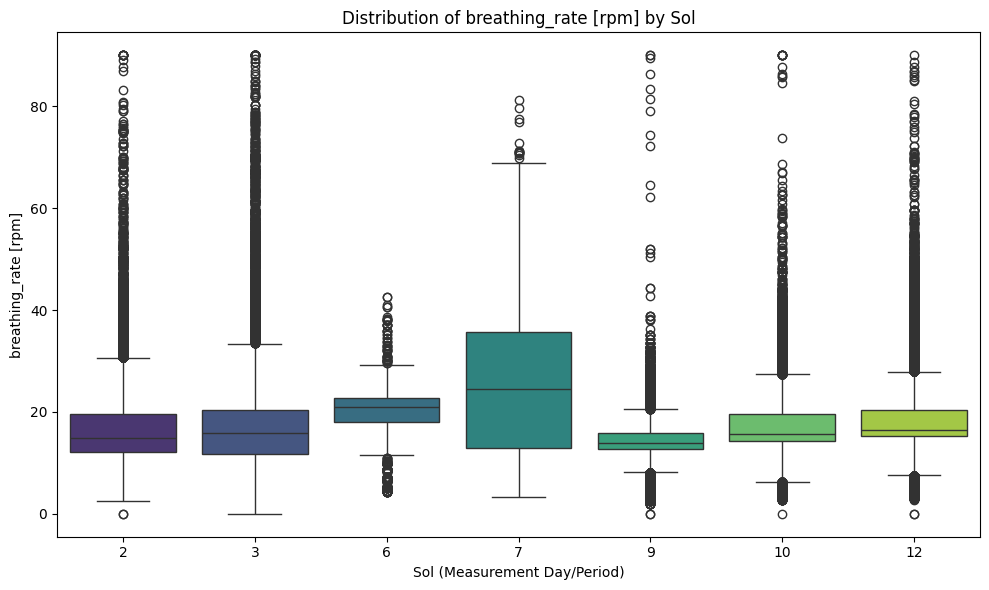



--- Visualization and Analysis for: SPO2 [%] ---
Statistical Test: Kruskal-Wallis H-test
Result: H(6) = 77747.29, p < 0.001
Interpretation: A statistically significant difference was detected in the distribution of 'SPO2 [%]' across the different Sols (p < 0.001). This indicates that the median SPO2 [%] likely varies depending on the measurement period ('Sol').
Further investigation using post-hoc tests is necessary to determine which specific Sol periods differ significantly.

Generating Box Plot for SPO2 [%] across Sols...


C:\Users\User\AppData\Local\Temp\ipykernel_28344\1843296480.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Sol', y=variable, data=data_to_plot, palette="viridis") # Added palette


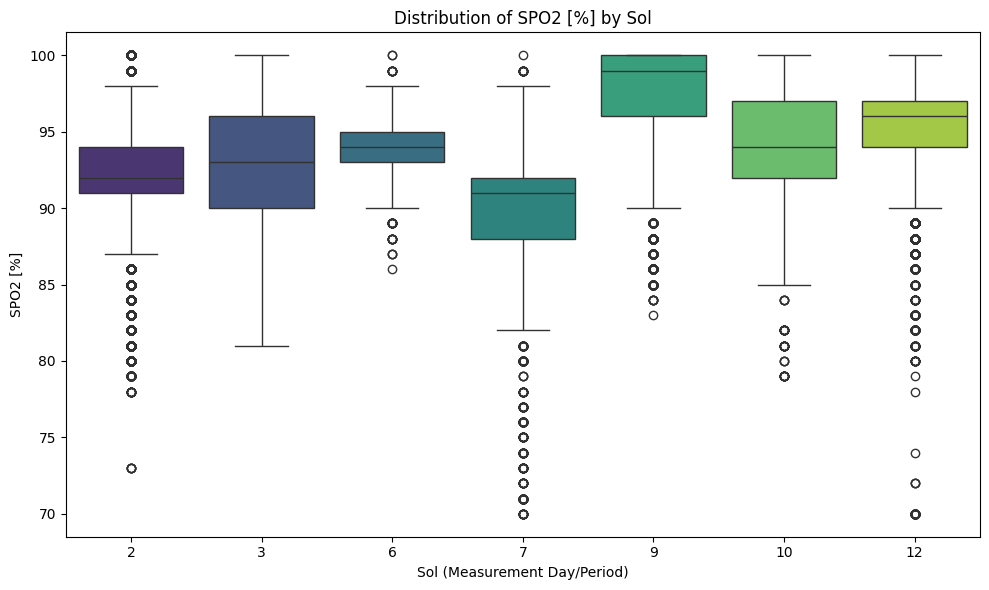



--- Visualization and Analysis for: PTT [s] ---
Statistical Test: Kruskal-Wallis H-test
Result: H(8) = 25394.58, p < 0.001
Interpretation: A statistically significant difference was detected in the distribution of 'PTT [s]' across the different Sols (p < 0.001). This indicates that the median PTT [s] likely varies depending on the measurement period ('Sol').
Further investigation using post-hoc tests is necessary to determine which specific Sol periods differ significantly.

Generating Box Plot for PTT [s] across Sols...


C:\Users\User\AppData\Local\Temp\ipykernel_28344\1843296480.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Sol', y=variable, data=data_to_plot, palette="viridis") # Added palette


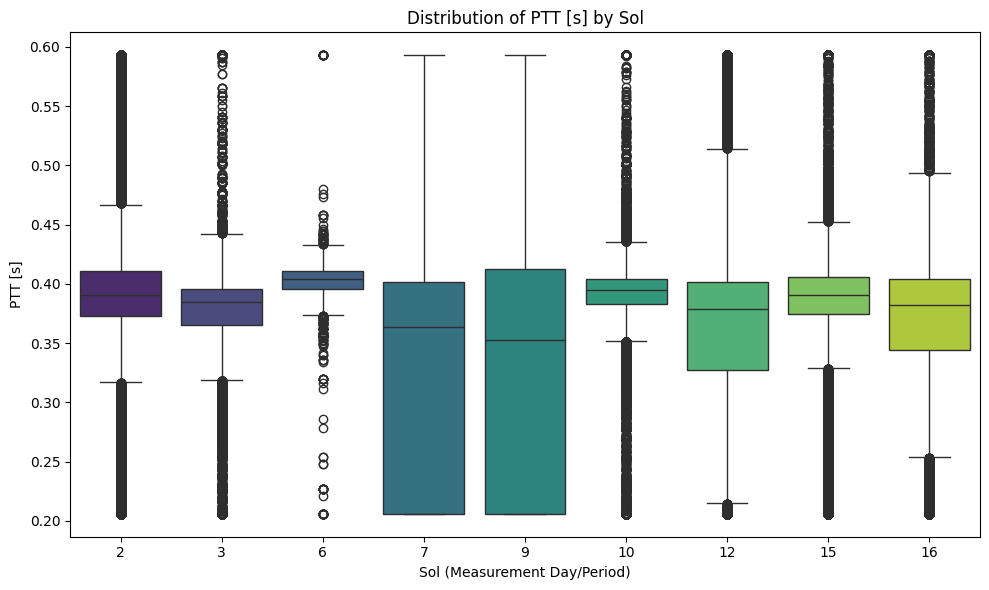



--- Visualization and Analysis for: minute_ventilation [mL/min] ---
Statistical Test: Kruskal-Wallis H-test
Result: H(6) = 27559.42, p < 0.001
Interpretation: A statistically significant difference was detected in the distribution of 'minute_ventilation [mL/min]' across the different Sols (p < 0.001). This indicates that the median minute_ventilation [mL/min] likely varies depending on the measurement period ('Sol').
Further investigation using post-hoc tests is necessary to determine which specific Sol periods differ significantly.

Generating Box Plot for minute_ventilation [mL/min] across Sols...


C:\Users\User\AppData\Local\Temp\ipykernel_28344\1843296480.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Sol', y=variable, data=data_to_plot, palette="viridis") # Added palette


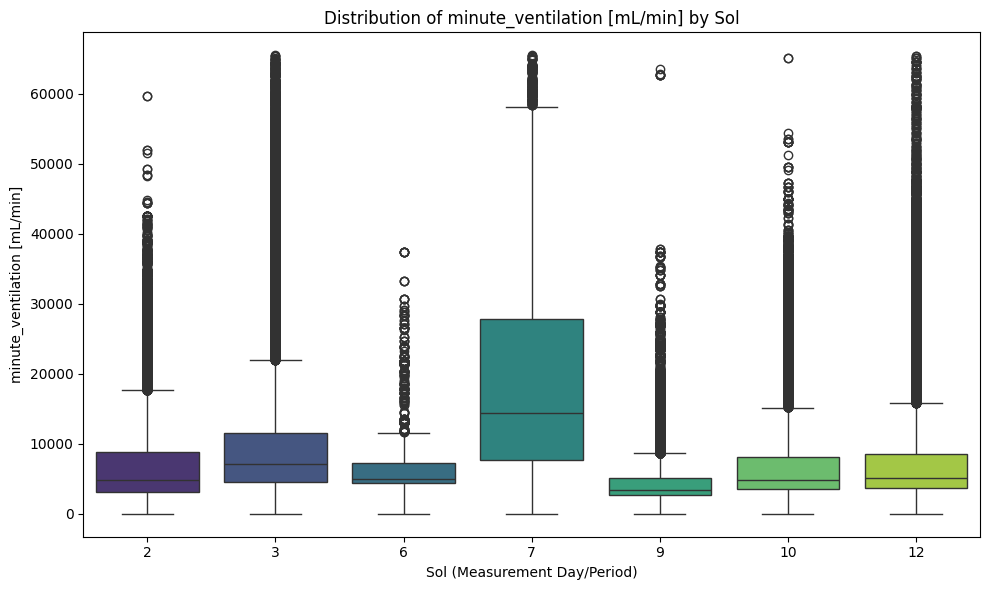



--- Visualization and Analysis for: systolic_pressure [mmHg] ---
Statistical Test: Kruskal-Wallis H-test
Result: H(6) = 22014.00, p < 0.001
Interpretation: A statistically significant difference was detected in the distribution of 'systolic_pressure [mmHg]' across the different Sols (p < 0.001). This indicates that the median systolic_pressure [mmHg] likely varies depending on the measurement period ('Sol').
Further investigation using post-hoc tests is necessary to determine which specific Sol periods differ significantly.

Generating Box Plot for systolic_pressure [mmHg] across Sols...


C:\Users\User\AppData\Local\Temp\ipykernel_28344\1843296480.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Sol', y=variable, data=data_to_plot, palette="viridis") # Added palette


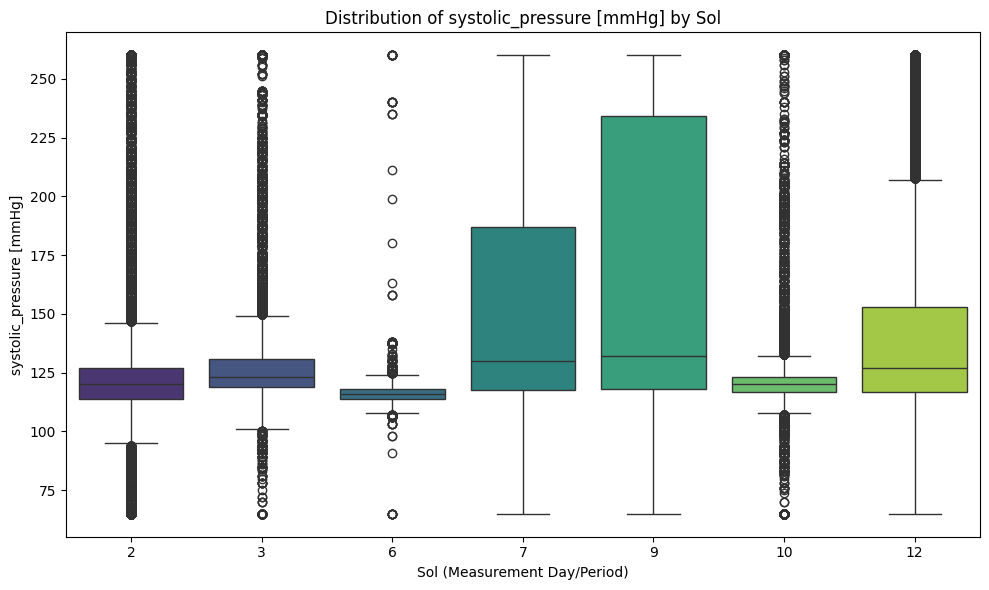



--- Visualization and Analysis for: activity [g] ---
Statistical Test: Kruskal-Wallis H-test
Result: H(6) = 20864.97, p < 0.001
Interpretation: A statistically significant difference was detected in the distribution of 'activity [g]' across the different Sols (p < 0.001). This indicates that the median activity [g] likely varies depending on the measurement period ('Sol').
Further investigation using post-hoc tests is necessary to determine which specific Sol periods differ significantly.

Generating Box Plot for activity [g] across Sols...


C:\Users\User\AppData\Local\Temp\ipykernel_28344\1843296480.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Sol', y=variable, data=data_to_plot, palette="viridis") # Added palette


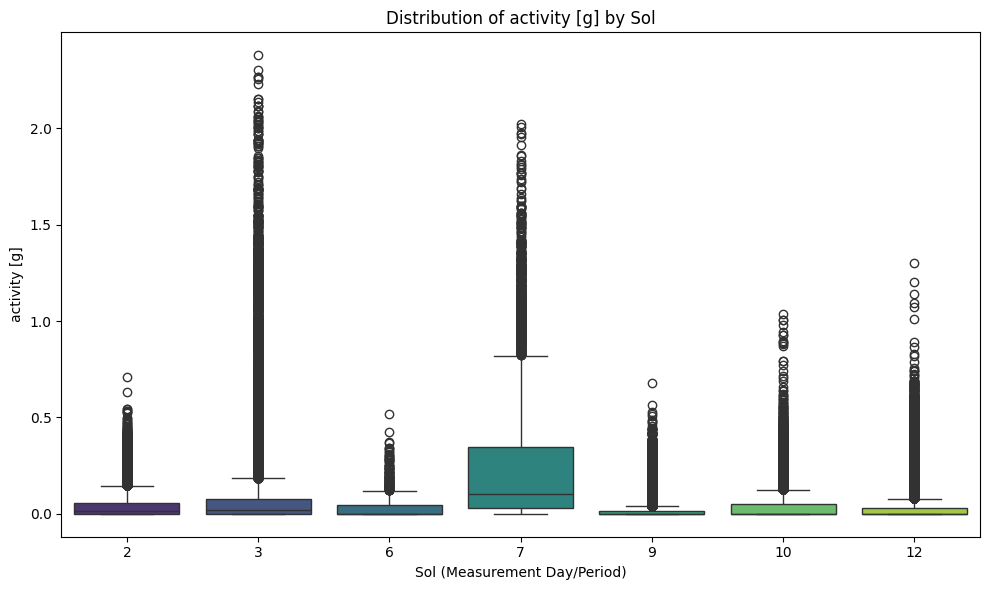



--- Visualization and Analysis for: temperature_celcius [C] ---
Statistical Test: Kruskal-Wallis H-test
Result: H(6) = 22739.76, p < 0.001
Interpretation: A statistically significant difference was detected in the distribution of 'temperature_celcius [C]' across the different Sols (p < 0.001). This indicates that the median temperature_celcius [C] likely varies depending on the measurement period ('Sol').
Further investigation using post-hoc tests is necessary to determine which specific Sol periods differ significantly.

Generating Box Plot for temperature_celcius [C] across Sols...


C:\Users\User\AppData\Local\Temp\ipykernel_28344\1843296480.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Sol', y=variable, data=data_to_plot, palette="viridis") # Added palette


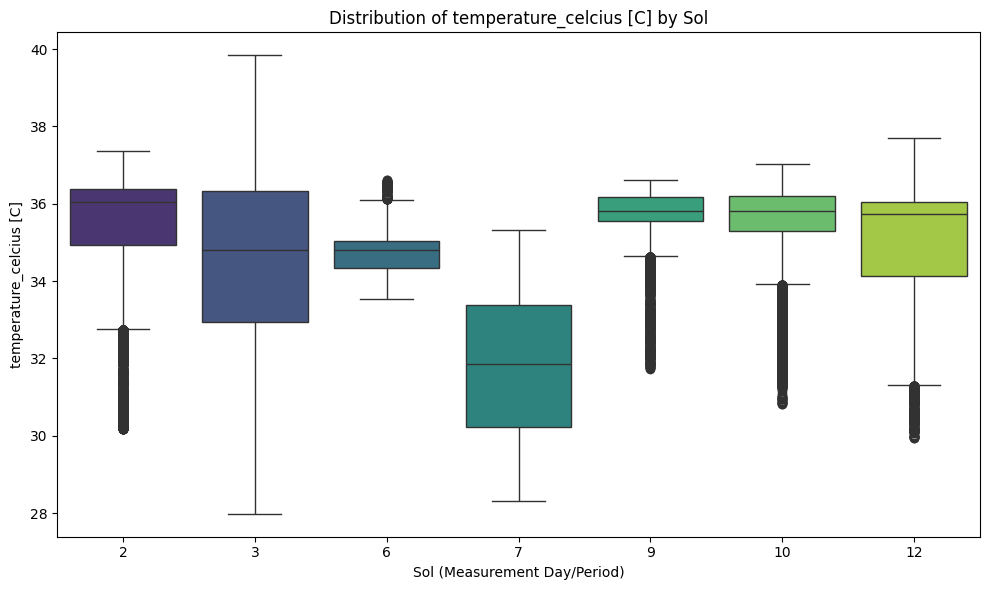



--- Visualization and Analysis for: heart_rate [bpm] ---
Statistical Test: Kruskal-Wallis H-test
Result: H(6) = 50567.85, p < 0.001
Interpretation: A statistically significant difference was detected in the distribution of 'heart_rate [bpm]' across the different Sols (p < 0.001). This indicates that the median heart_rate [bpm] likely varies depending on the measurement period ('Sol').
Further investigation using post-hoc tests is necessary to determine which specific Sol periods differ significantly.

Generating Box Plot for heart_rate [bpm] across Sols...


C:\Users\User\AppData\Local\Temp\ipykernel_28344\1843296480.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Sol', y=variable, data=data_to_plot, palette="viridis") # Added palette


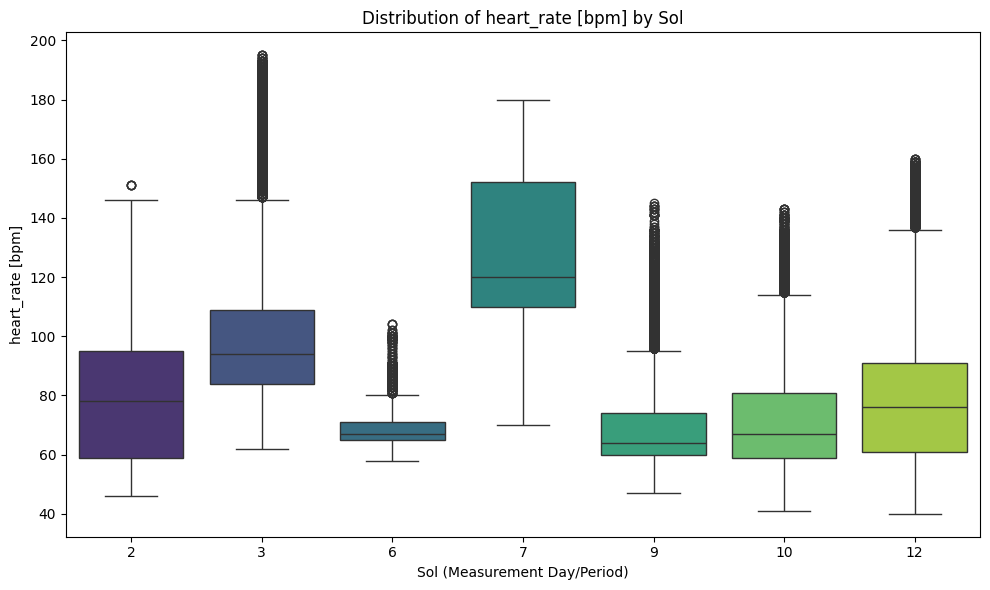



--- Visualization and Analysis for: cadence [spm] ---
Statistical Test: Kruskal-Wallis H-test
Result: H(6) = 14061.79, p < 0.001
Interpretation: A statistically significant difference was detected in the distribution of 'cadence [spm]' across the different Sols (p < 0.001). This indicates that the median cadence [spm] likely varies depending on the measurement period ('Sol').
Further investigation using post-hoc tests is necessary to determine which specific Sol periods differ significantly.

Generating Box Plot for cadence [spm] across Sols...


C:\Users\User\AppData\Local\Temp\ipykernel_28344\1843296480.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Sol', y=variable, data=data_to_plot, palette="viridis") # Added palette


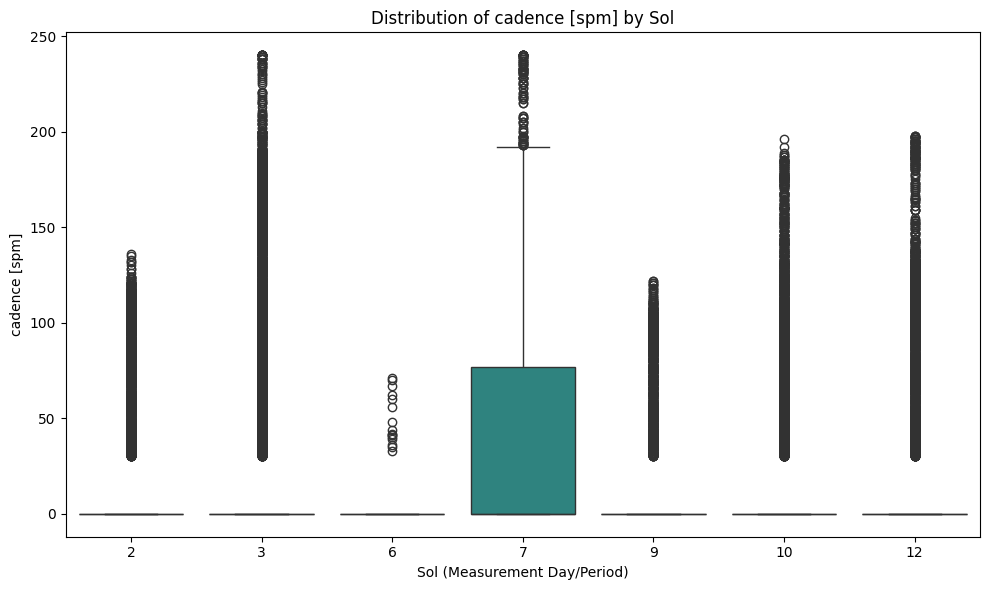


--- End of Visualizations ---


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Assuming df_clean is your cleaned DataFrame
# Assuming results_summary is the dictionary holding the Kruskal-Wallis results from the previous step
# Example structure of results_summary:
# results_summary = {
#     'breathing_rate [rpm]': {'statistic': 18367.14, 'p_value': 0.0, 'df': 6},
#     'SPO2 [%]': {'statistic': 77747.29, 'p_value': 0.0, 'df': 6},
#     # ... other variables
# }

# --- Visualize Variable Distributions Across Sols with Statistical Summary ---

print("--- Variable Distributions Across Sols (Box Plots with Kruskal-Wallis Summary) ---")

# Identify numerical columns to visualize (same as used for Kruskal-Wallis)
numerical_cols = df_clean.select_dtypes(include=np.number).columns.tolist()
cols_to_exclude = ['Sol']
variables_to_visualize = [col for col in numerical_cols if col not in cols_to_exclude]

for variable in variables_to_visualize:

    # --- Statistical Summary ---
    print(f"\n\n--- Visualization and Analysis for: {variable} ---")

    if variable in results_summary:
        # Retrieve results
        result_data = results_summary[variable]
        stat = result_data['statistic']
        p_value = result_data['p_value']
        degrees_freedom = result_data['df']

        # Report results adhering to the results.mdc format
        print(f"Statistical Test: Kruskal-Wallis H-test")
        p_value_str = f"p = {p_value:.3f}" if p_value >= 0.001 else "p < 0.001"
        print(f"Result: H({degrees_freedom}) = {stat:.2f}, {p_value_str}")

        # Interpretation
        if p_value < 0.05:
            print(f"Interpretation: A statistically significant difference was detected in the distribution of '{variable}' across the different Sols ({p_value_str}). This indicates that the median {variable} likely varies depending on the measurement period ('Sol').")
            print("Further investigation using post-hoc tests is necessary to determine which specific Sol periods differ significantly.")
        else:
            print(f"Interpretation: No statistically significant difference was detected in the distribution of '{variable}' across the different Sols ({p_value_str}). Based on this test, there is insufficient evidence to conclude that the median {variable} varies significantly between measurement periods.")
    else:
        print(f"Statistical results for {variable} not found in summary.")
        # Optionally run the test here if needed, or indicate it wasn't tested

    # --- Visualization (Box Plot) ---
    print(f"\nGenerating Box Plot for {variable} across Sols...")

    # Check if column exists and has data to plot
    if variable not in df_clean.columns or df_clean[variable].isnull().all():
        print(f"Cannot generate plot for {variable}: Column not found or contains only NaN values.")
        continue

    # Create the plot
    plt.figure(figsize=(10, 6)) # Adjust figure size as needed
    # Drop NaNs specifically for this variable before plotting
    data_to_plot = df_clean[['Sol', variable]].dropna()

    # Check if data remains after dropping NaNs
    if data_to_plot.empty or data_to_plot['Sol'].nunique() < 1:
         print(f"Cannot generate plot for {variable}: No valid data remains after dropping NaNs.")
         continue

    sns.boxplot(x='Sol', y=variable, data=data_to_plot, palette="viridis") # Added palette
    plt.title(f'Distribution of {variable} by Sol')
    plt.xlabel('Sol (Measurement Day/Period)')
    plt.ylabel(f'{variable}')
    plt.tight_layout()
    plt.show() # Display the plot


print("\n--- End of Visualizations ---")


--- Mean Variable Levels Across Sols (Bar Plots with 95% CI & Kruskal-Wallis Summary) ---


--- Visualization and Analysis for: breathing_rate [rpm] ---
Statistical Test: Kruskal-Wallis H-test (Comparing Medians)
Result: H(6) = 18367.14, p < 0.001
Interpretation: A statistically significant difference was detected in the distribution (median) of 'breathing_rate [rpm]' across Sols (p < 0.001).

Generating Bar Plot (Mean ± 95% CI) for breathing_rate [rpm] across Sols...


C:\Users\User\AppData\Local\Temp\ipykernel_28344\807787487.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Sol', y=variable, data=data_to_plot, palette="viridis", errorbar="ci")


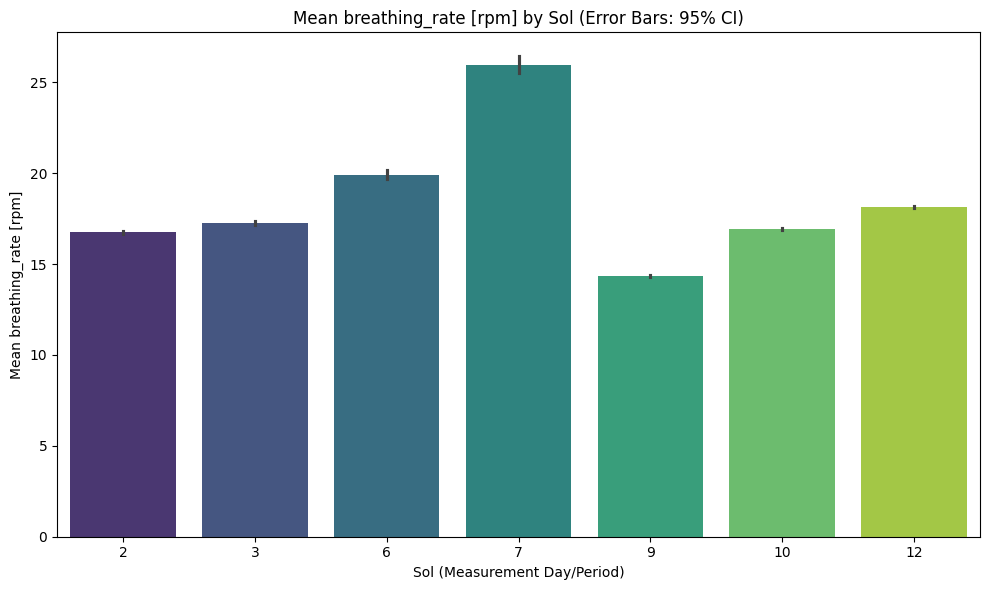



--- Visualization and Analysis for: SPO2 [%] ---
Statistical Test: Kruskal-Wallis H-test (Comparing Medians)
Result: H(6) = 77747.29, p < 0.001
Interpretation: A statistically significant difference was detected in the distribution (median) of 'SPO2 [%]' across Sols (p < 0.001).

Generating Bar Plot (Mean ± 95% CI) for SPO2 [%] across Sols...


C:\Users\User\AppData\Local\Temp\ipykernel_28344\807787487.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Sol', y=variable, data=data_to_plot, palette="viridis", errorbar="ci")


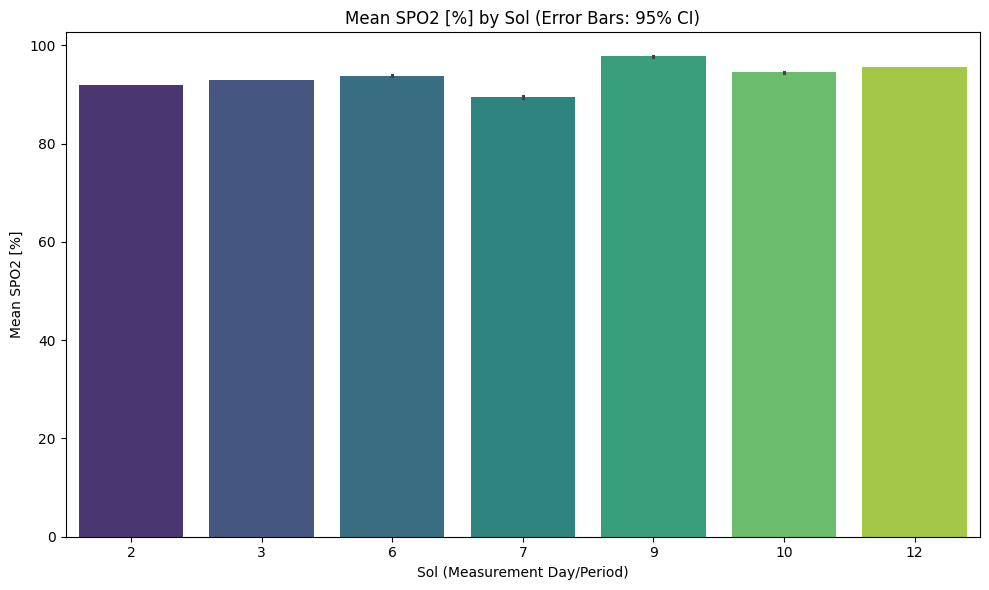



--- Visualization and Analysis for: PTT [s] ---
Statistical Test: Kruskal-Wallis H-test (Comparing Medians)
Result: H(8) = 25394.58, p < 0.001
Interpretation: A statistically significant difference was detected in the distribution (median) of 'PTT [s]' across Sols (p < 0.001).

Generating Bar Plot (Mean ± 95% CI) for PTT [s] across Sols...


C:\Users\User\AppData\Local\Temp\ipykernel_28344\807787487.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Sol', y=variable, data=data_to_plot, palette="viridis", errorbar="ci")


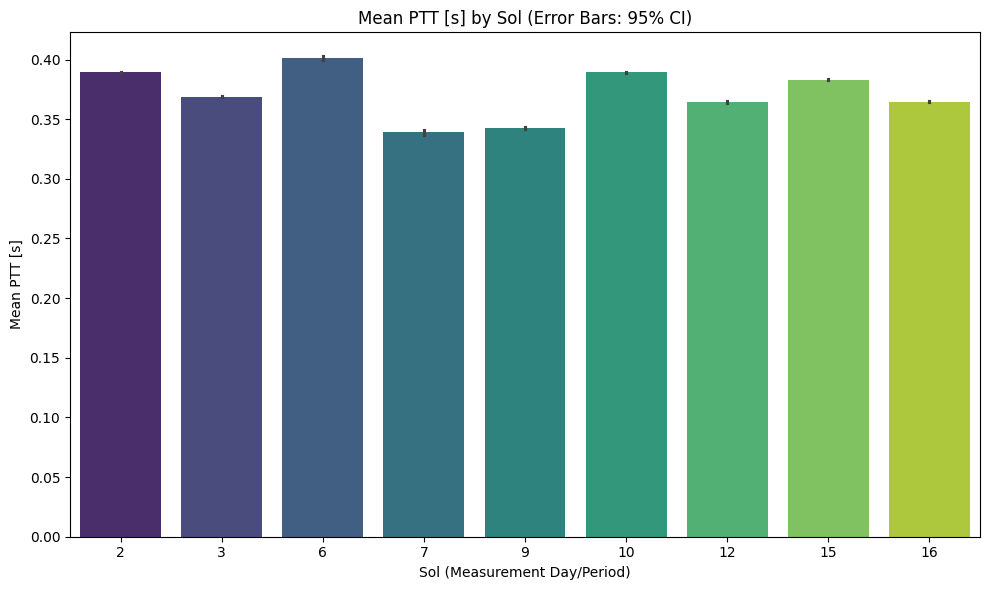



--- Visualization and Analysis for: minute_ventilation [mL/min] ---
Statistical Test: Kruskal-Wallis H-test (Comparing Medians)
Result: H(6) = 27559.42, p < 0.001
Interpretation: A statistically significant difference was detected in the distribution (median) of 'minute_ventilation [mL/min]' across Sols (p < 0.001).

Generating Bar Plot (Mean ± 95% CI) for minute_ventilation [mL/min] across Sols...


C:\Users\User\AppData\Local\Temp\ipykernel_28344\807787487.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Sol', y=variable, data=data_to_plot, palette="viridis", errorbar="ci")


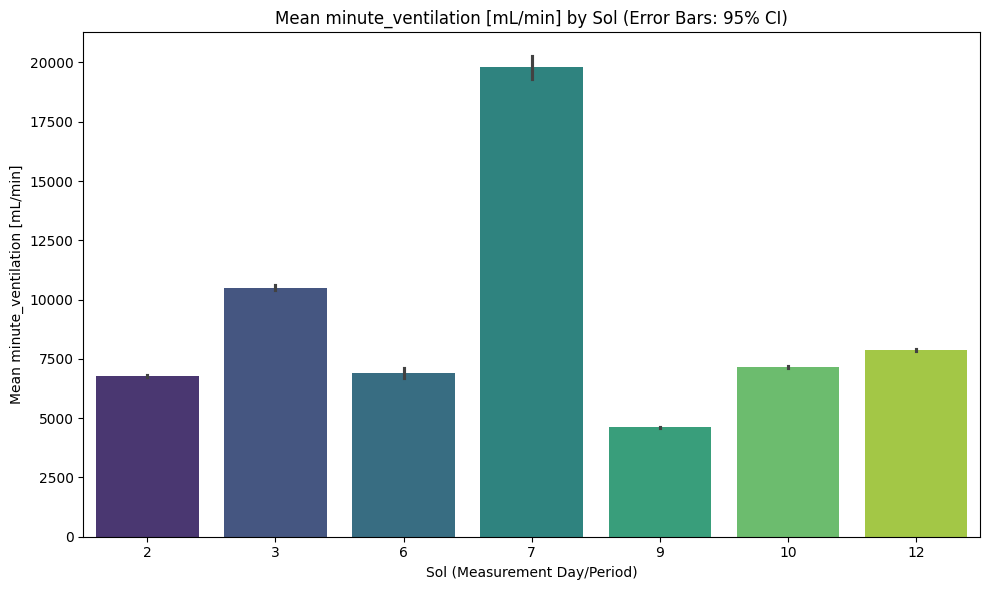



--- Visualization and Analysis for: systolic_pressure [mmHg] ---
Statistical Test: Kruskal-Wallis H-test (Comparing Medians)
Result: H(6) = 22014.00, p < 0.001
Interpretation: A statistically significant difference was detected in the distribution (median) of 'systolic_pressure [mmHg]' across Sols (p < 0.001).

Generating Bar Plot (Mean ± 95% CI) for systolic_pressure [mmHg] across Sols...


C:\Users\User\AppData\Local\Temp\ipykernel_28344\807787487.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Sol', y=variable, data=data_to_plot, palette="viridis", errorbar="ci")


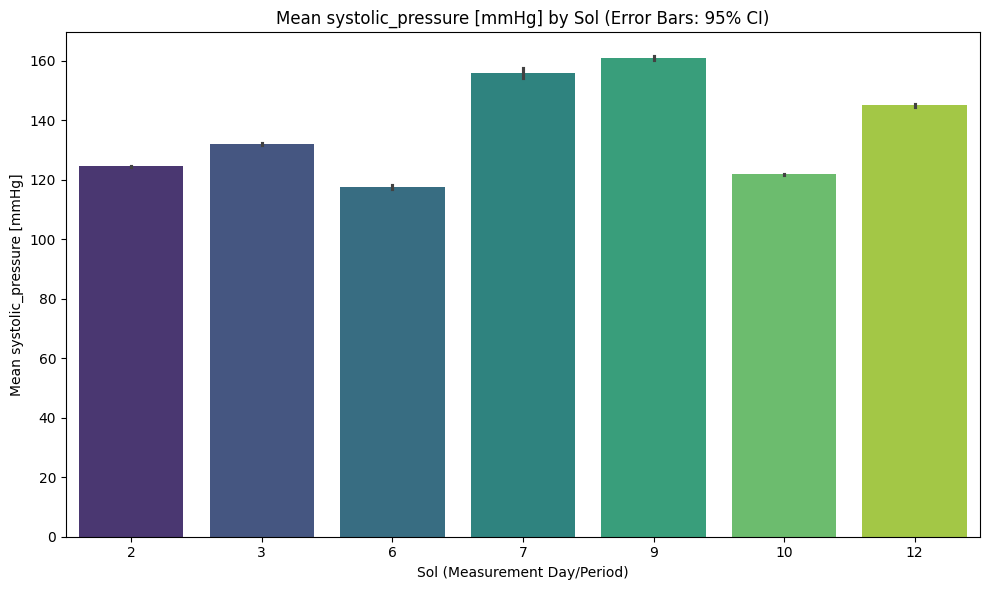



--- Visualization and Analysis for: activity [g] ---
Statistical Test: Kruskal-Wallis H-test (Comparing Medians)
Result: H(6) = 20864.97, p < 0.001
Interpretation: A statistically significant difference was detected in the distribution (median) of 'activity [g]' across Sols (p < 0.001).

Generating Bar Plot (Mean ± 95% CI) for activity [g] across Sols...


C:\Users\User\AppData\Local\Temp\ipykernel_28344\807787487.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Sol', y=variable, data=data_to_plot, palette="viridis", errorbar="ci")


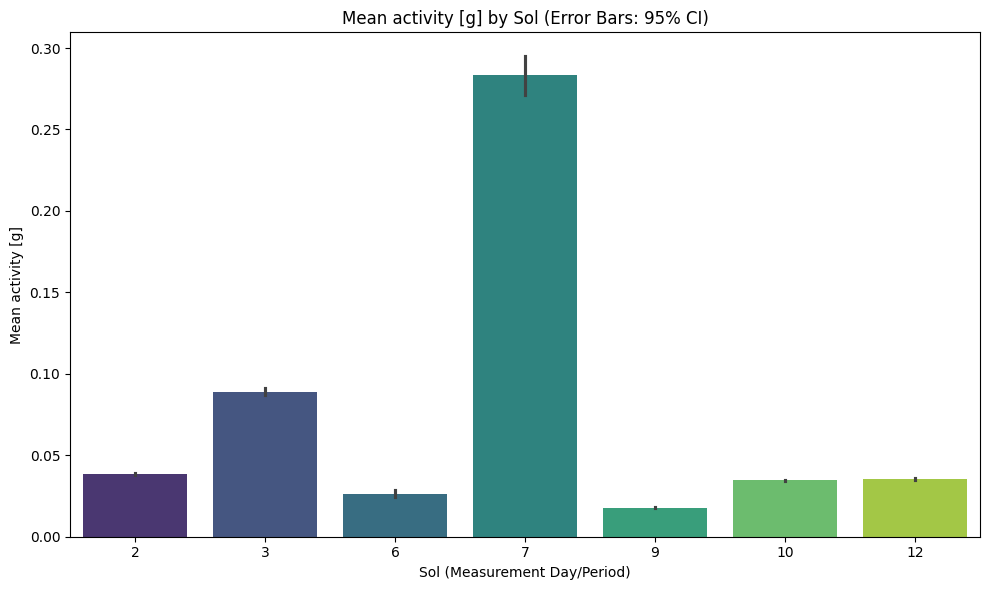



--- Visualization and Analysis for: temperature_celcius [C] ---
Statistical Test: Kruskal-Wallis H-test (Comparing Medians)
Result: H(6) = 22739.76, p < 0.001
Interpretation: A statistically significant difference was detected in the distribution (median) of 'temperature_celcius [C]' across Sols (p < 0.001).

Generating Bar Plot (Mean ± 95% CI) for temperature_celcius [C] across Sols...


C:\Users\User\AppData\Local\Temp\ipykernel_28344\807787487.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Sol', y=variable, data=data_to_plot, palette="viridis", errorbar="ci")


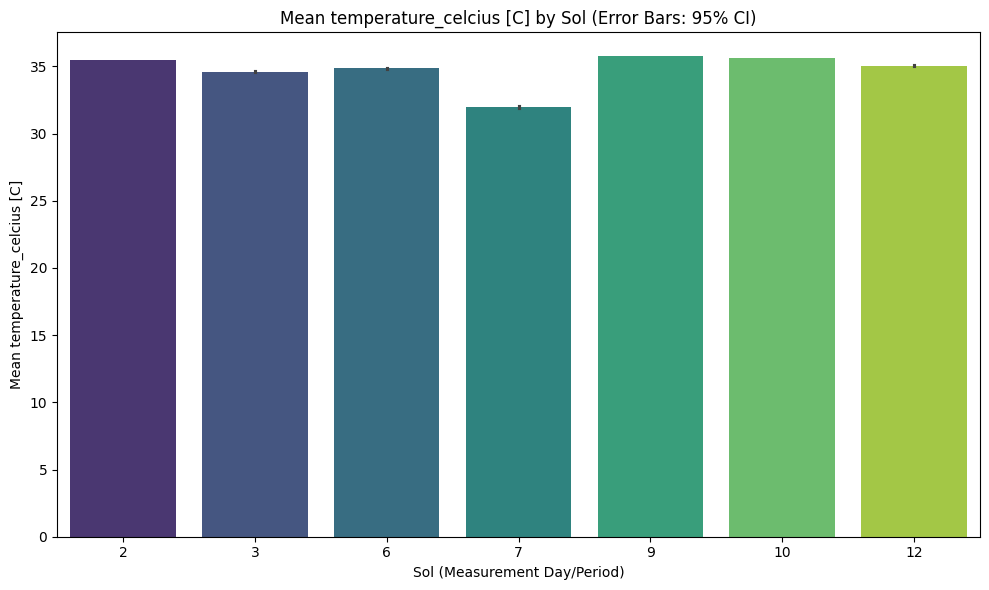



--- Visualization and Analysis for: heart_rate [bpm] ---
Statistical Test: Kruskal-Wallis H-test (Comparing Medians)
Result: H(6) = 50567.85, p < 0.001
Interpretation: A statistically significant difference was detected in the distribution (median) of 'heart_rate [bpm]' across Sols (p < 0.001).

Generating Bar Plot (Mean ± 95% CI) for heart_rate [bpm] across Sols...


C:\Users\User\AppData\Local\Temp\ipykernel_28344\807787487.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Sol', y=variable, data=data_to_plot, palette="viridis", errorbar="ci")


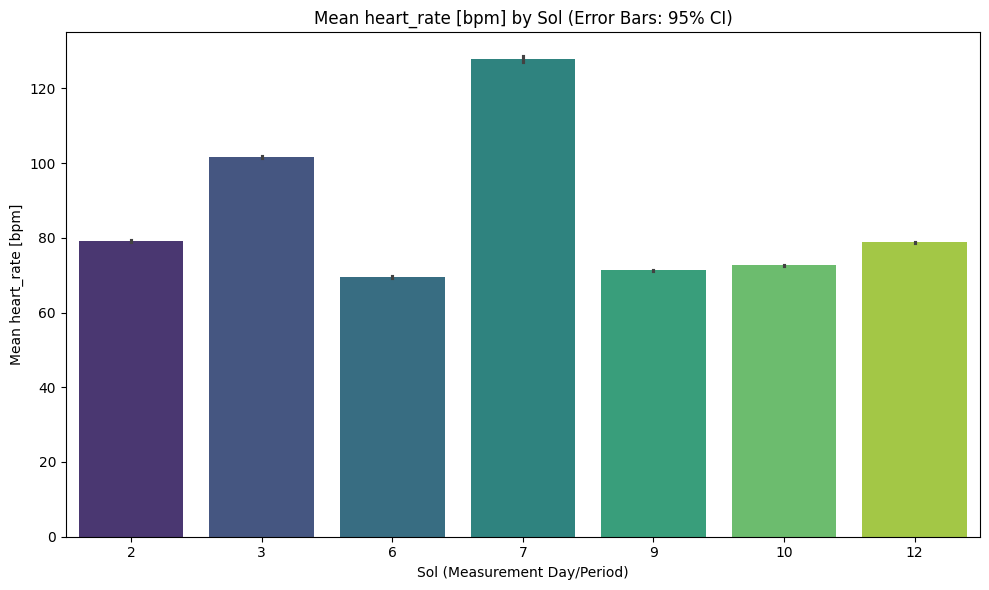



--- Visualization and Analysis for: cadence [spm] ---
Statistical Test: Kruskal-Wallis H-test (Comparing Medians)
Result: H(6) = 14061.79, p < 0.001
Interpretation: A statistically significant difference was detected in the distribution (median) of 'cadence [spm]' across Sols (p < 0.001).

Generating Bar Plot (Mean ± 95% CI) for cadence [spm] across Sols...


C:\Users\User\AppData\Local\Temp\ipykernel_28344\807787487.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Sol', y=variable, data=data_to_plot, palette="viridis", errorbar="ci")


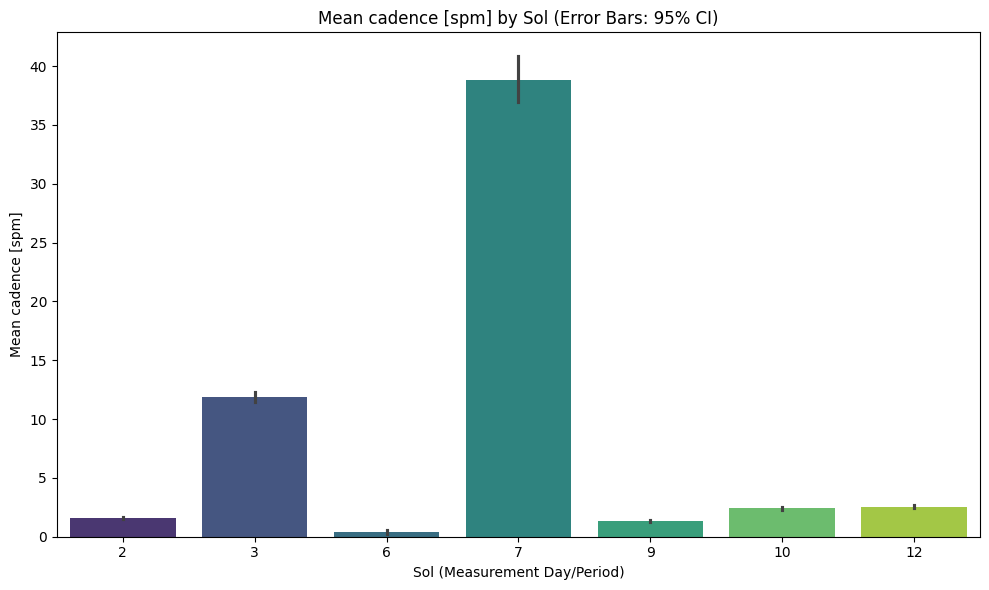


--- End of Visualizations ---


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Assuming df_clean is your cleaned DataFrame
# Assuming results_summary is the dictionary holding the Kruskal-Wallis results

# --- Visualize Mean Variable Levels Across Sols with Statistical Summary ---

print("--- Mean Variable Levels Across Sols (Bar Plots with 95% CI & Kruskal-Wallis Summary) ---")

# Identify numerical columns to visualize
numerical_cols = df_clean.select_dtypes(include=np.number).columns.tolist()
cols_to_exclude = ['Sol']
variables_to_visualize = [col for col in numerical_cols if col not in cols_to_exclude]

for variable in variables_to_visualize:

    # --- Statistical Summary (Kruskal-Wallis) ---
    print(f"\n\n--- Visualization and Analysis for: {variable} ---")

    if variable in results_summary:
        result_data = results_summary[variable]
        stat = result_data['statistic']
        p_value = result_data['p_value']
        degrees_freedom = result_data['df']

        print(f"Statistical Test: Kruskal-Wallis H-test (Comparing Medians)")
        p_value_str = f"p = {p_value:.3f}" if p_value >= 0.001 else "p < 0.001"
        print(f"Result: H({degrees_freedom}) = {stat:.2f}, {p_value_str}")

        if p_value < 0.05:
            print(f"Interpretation: A statistically significant difference was detected in the distribution (median) of '{variable}' across Sols ({p_value_str}).")
        else:
            print(f"Interpretation: No statistically significant difference was detected in the distribution (median) of '{variable}' across Sols ({p_value_str}).")
    else:
        print(f"Statistical results for {variable} not found in summary.")

    # --- Visualization (Bar Plot - Mean with 95% CI) ---
    print(f"\nGenerating Bar Plot (Mean ± 95% CI) for {variable} across Sols...")

    # Check if column exists and has data to plot
    if variable not in df_clean.columns or df_clean[variable].isnull().all():
        print(f"Cannot generate plot for {variable}: Column not found or contains only NaN values.")
        continue

    # Prepare data (drop NaNs for this variable)
    data_to_plot = df_clean[['Sol', variable]].dropna()

    # Check if data remains after dropping NaNs and if there's more than one Sol
    if data_to_plot.empty or data_to_plot['Sol'].nunique() < 1:
         print(f"Cannot generate plot for {variable}: No valid data remains after dropping NaNs or only one Sol present.")
         continue

    plt.figure(figsize=(10, 6))
    # seaborn.barplot estimates the mean and plots the 95% CI using bootstrapping by default
    sns.barplot(x='Sol', y=variable, data=data_to_plot, palette="viridis", errorbar="ci")
    plt.title(f'Mean {variable} by Sol (Error Bars: 95% CI)')
    plt.xlabel('Sol (Measurement Day/Period)')
    plt.ylabel(f'Mean {variable}')
    plt.tight_layout()
    plt.show()


print("\n--- End of Visualizations ---")

In [18]:
import scikit_posthocs as sp
import pandas as pd
import numpy as np

# Assuming df_clean is your cleaned DataFrame
# Assuming results_summary holds the Kruskal-Wallis results

print("\n--- Dunn's Post-Hoc Test Results (Pairwise Comparisons Across Sols) ---")

variables_to_analyze = [var for var, res in results_summary.items() if res['p_value'] < 0.05]
dunn_results_all = {} # Dictionary to store results matrices

for variable in variables_to_analyze:
    print(f"\n--- Post-Hoc Analysis for: {variable} ---")

    if variable not in df_clean.columns or df_clean[variable].isnull().all():
        print(f"Skipping {variable}: Column not found or contains only NaN values.")
        continue

    data_for_posthoc = df_clean[['Sol', variable]].dropna()

    if data_for_posthoc['Sol'].nunique() < 2:
         print(f"Skipping {variable}: Fewer than two Sol groups contain valid data.")
         continue
    else:
        try:
            # Perform Dunn's test with Bonferroni correction
            dunn_result = sp.posthoc_dunn(data_for_posthoc, val_col=variable, group_col='Sol', p_adjust='bonferroni')
            dunn_results_all[variable] = dunn_result # Store the results

            print(f"Dunn's Test Results Matrix (Bonferroni-adjusted p-values) for {variable}:")
            # Display the results matrix, formatting p-values
            with pd.option_context('display.float_format', '{:.3f}'.format):
                print(dunn_result)
            print("-" * 50)

        except Exception as e:
            print(f"An error occurred during Dunn's post-hoc test for {variable}: {e}")

print("\n--- End of Post-Hoc Analysis ---")


--- Dunn's Post-Hoc Test Results (Pairwise Comparisons Across Sols) ---

--- Post-Hoc Analysis for: breathing_rate [rpm] ---
Dunn's Test Results Matrix (Bonferroni-adjusted p-values) for breathing_rate [rpm]:
      2     3     6     7     9     10    12
2  1.000 0.000 0.000 0.000 0.000 0.000 0.000
3  0.000 1.000 0.000 0.000 0.000 0.000 0.000
6  0.000 0.000 1.000 0.000 0.000 0.000 0.000
7  0.000 0.000 0.000 1.000 0.000 0.000 0.000
9  0.000 0.000 0.000 0.000 1.000 0.000 0.000
10 0.000 0.000 0.000 0.000 0.000 1.000 0.000
12 0.000 0.000 0.000 0.000 0.000 0.000 1.000
--------------------------------------------------

--- Post-Hoc Analysis for: SPO2 [%] ---
Dunn's Test Results Matrix (Bonferroni-adjusted p-values) for SPO2 [%]:
      2     3     6     7     9     10    12
2  1.000 0.000 0.000 0.000 0.000 0.000 0.000
3  0.000 1.000 0.000 0.000 0.000 0.000 0.000
6  0.000 0.000 1.000 0.000 0.000 0.000 0.000
7  0.000 0.000 0.000 1.000 0.000 0.000 0.000
9  0.000 0.000 0.000 0.000 1.000 0.000 0.


--- Variable Distributions Across Sols (Box Plots with Statistical Annotations) ---
Using Sol 2 as the reference for pairwise annotations.


--- Visualization and Analysis for: breathing_rate [rpm] ---
Overall Comparison: Kruskal-Wallis H-test
Result: H(6) = 18367.14, p < 0.001
Interpretation: Significant difference detected in the median of 'breathing_rate [rpm]' across Sols.
(Refer to printed Dunn's matrix for all pairwise p-values)

Generating Annotated Box Plot for breathing_rate [rpm] across Sols (vs Sol 2)...


C:\Users\User\AppData\Local\Temp\ipykernel_28344\1097530194.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=data_to_plot, x='Sol', y=variable, palette="viridis", order=plot_order)


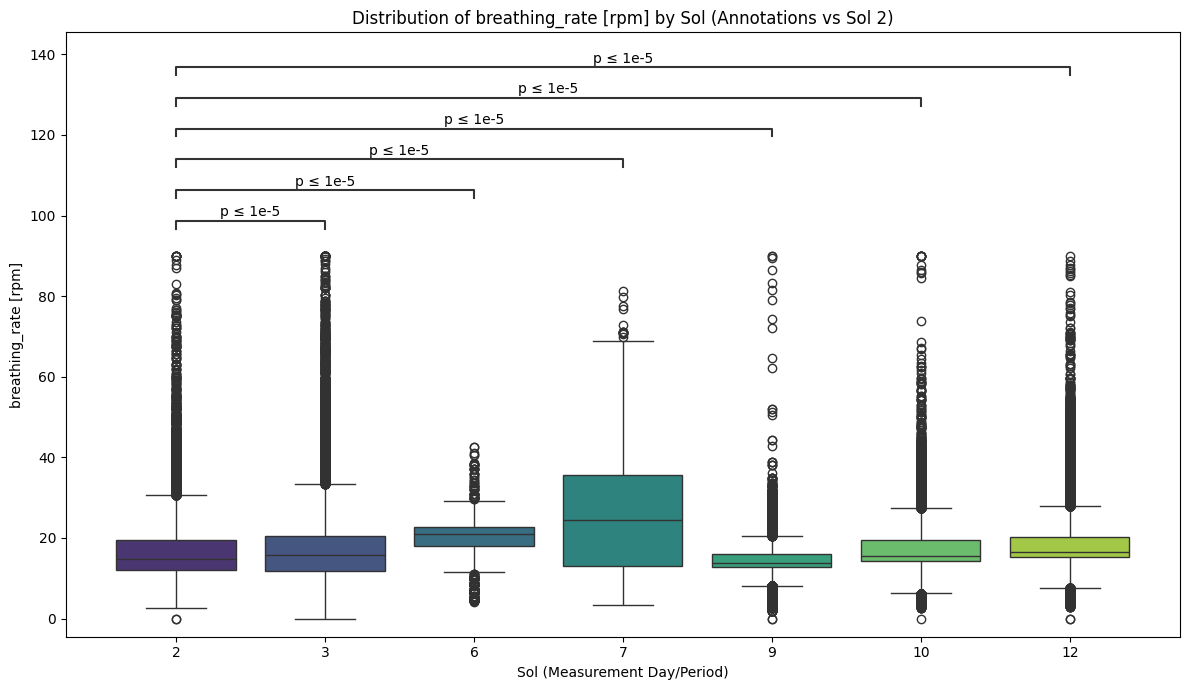



--- Visualization and Analysis for: SPO2 [%] ---
Overall Comparison: Kruskal-Wallis H-test
Result: H(6) = 77747.29, p < 0.001
Interpretation: Significant difference detected in the median of 'SPO2 [%]' across Sols.
(Refer to printed Dunn's matrix for all pairwise p-values)

Generating Annotated Box Plot for SPO2 [%] across Sols (vs Sol 2)...


C:\Users\User\AppData\Local\Temp\ipykernel_28344\1097530194.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=data_to_plot, x='Sol', y=variable, palette="viridis", order=plot_order)


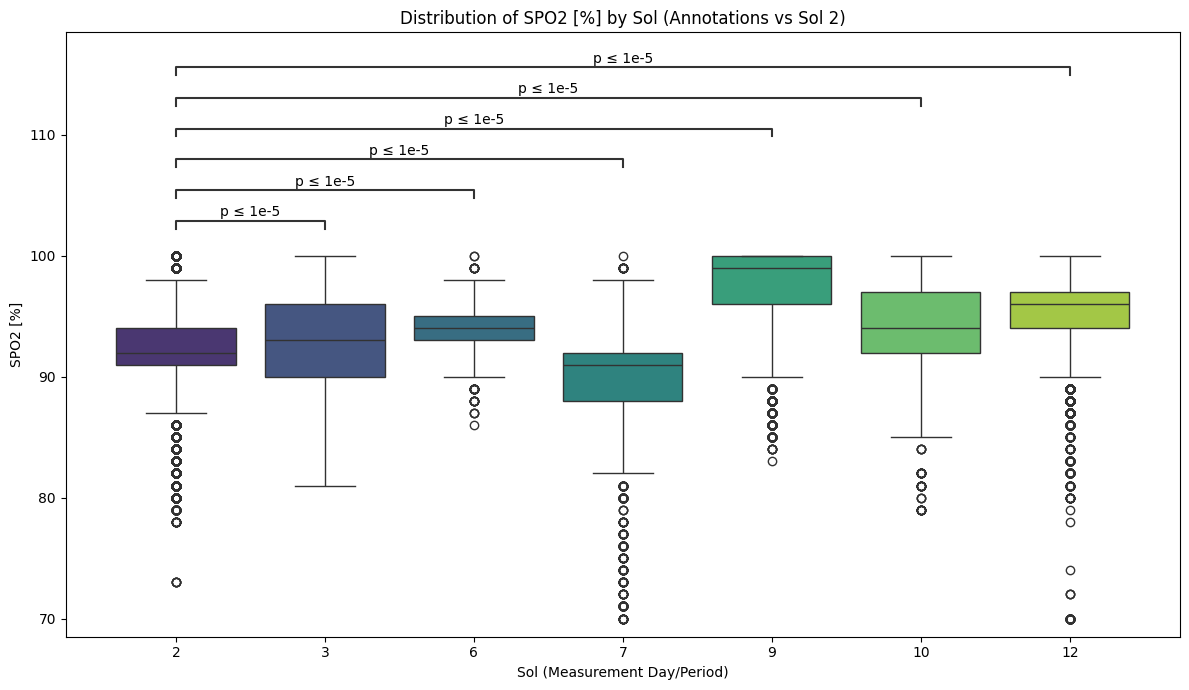



--- Visualization and Analysis for: PTT [s] ---
Overall Comparison: Kruskal-Wallis H-test
Result: H(8) = 25394.58, p < 0.001
Interpretation: Significant difference detected in the median of 'PTT [s]' across Sols.
(Refer to printed Dunn's matrix for all pairwise p-values)

Generating Annotated Box Plot for PTT [s] across Sols (vs Sol 2)...


C:\Users\User\AppData\Local\Temp\ipykernel_28344\1097530194.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=data_to_plot, x='Sol', y=variable, palette="viridis", order=plot_order)


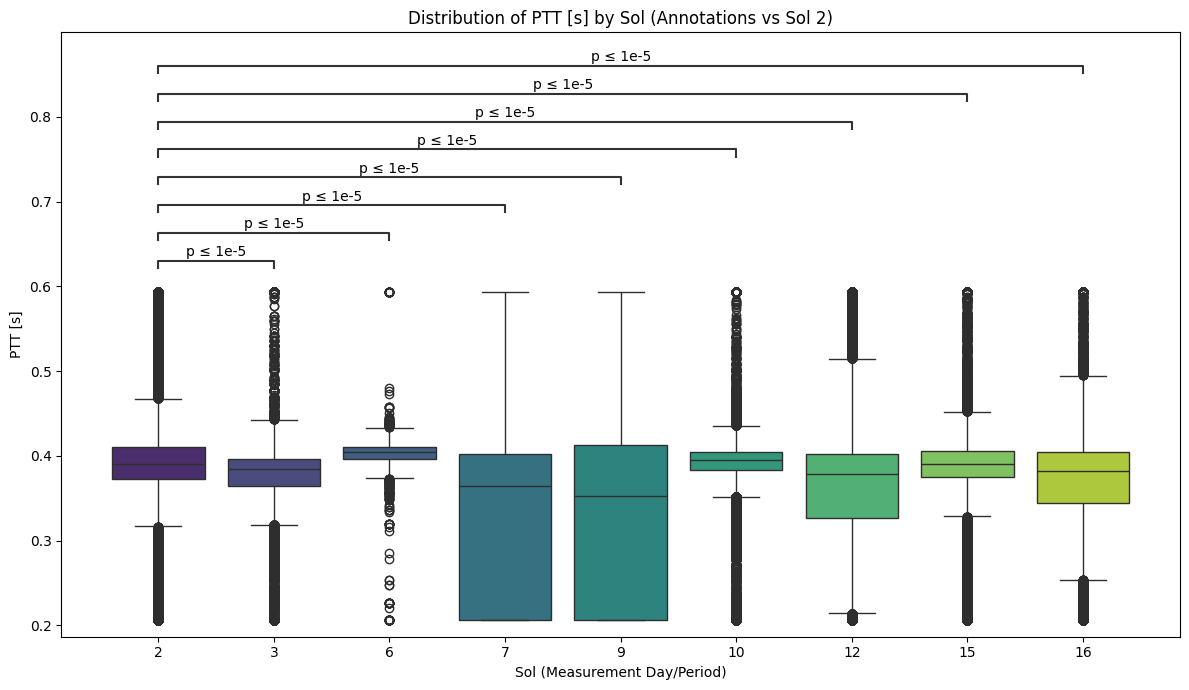



--- Visualization and Analysis for: minute_ventilation [mL/min] ---
Overall Comparison: Kruskal-Wallis H-test
Result: H(6) = 27559.42, p < 0.001
Interpretation: Significant difference detected in the median of 'minute_ventilation [mL/min]' across Sols.
(Refer to printed Dunn's matrix for all pairwise p-values)

Generating Annotated Box Plot for minute_ventilation [mL/min] across Sols (vs Sol 2)...


C:\Users\User\AppData\Local\Temp\ipykernel_28344\1097530194.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=data_to_plot, x='Sol', y=variable, palette="viridis", order=plot_order)


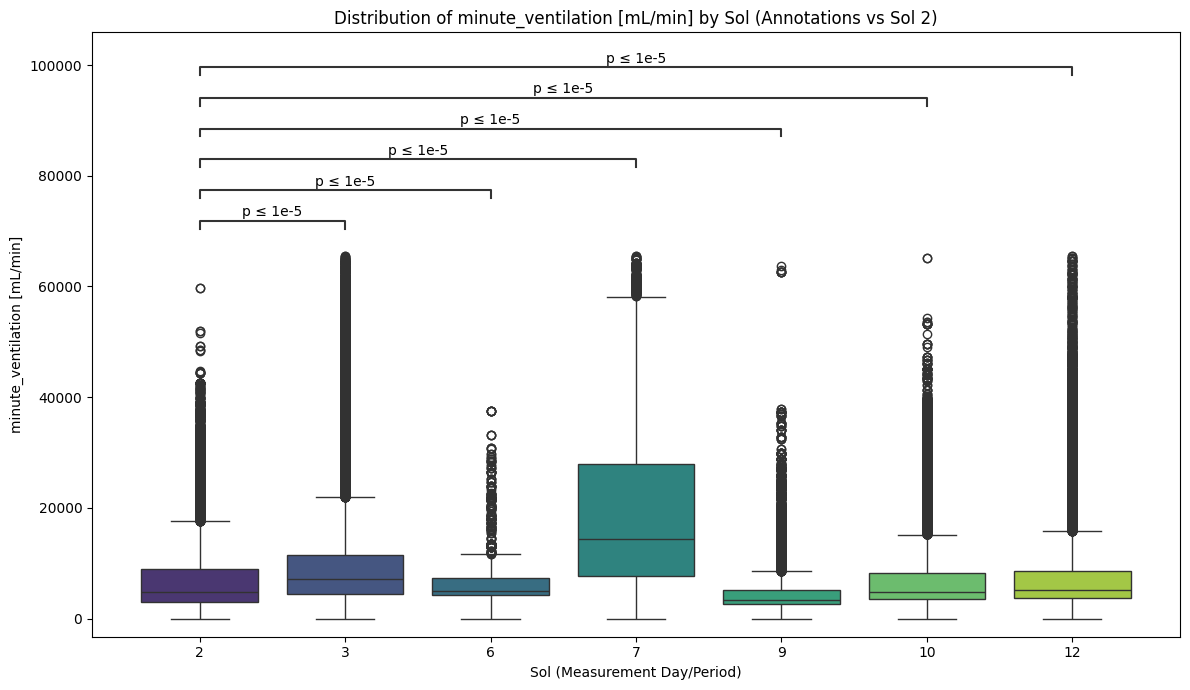



--- Visualization and Analysis for: systolic_pressure [mmHg] ---
Overall Comparison: Kruskal-Wallis H-test
Result: H(6) = 22014.00, p < 0.001
Interpretation: Significant difference detected in the median of 'systolic_pressure [mmHg]' across Sols.
(Refer to printed Dunn's matrix for all pairwise p-values)

Generating Annotated Box Plot for systolic_pressure [mmHg] across Sols (vs Sol 2)...


C:\Users\User\AppData\Local\Temp\ipykernel_28344\1097530194.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=data_to_plot, x='Sol', y=variable, palette="viridis", order=plot_order)


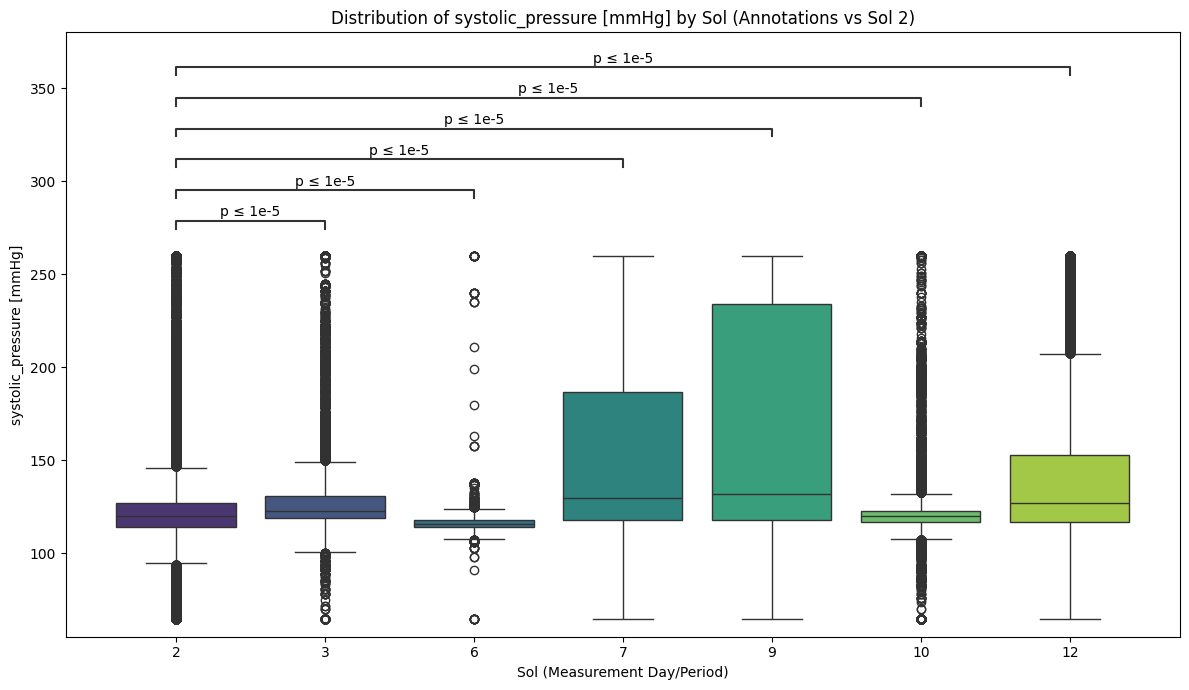



--- Visualization and Analysis for: activity [g] ---
Overall Comparison: Kruskal-Wallis H-test
Result: H(6) = 20864.97, p < 0.001
Interpretation: Significant difference detected in the median of 'activity [g]' across Sols.
(Refer to printed Dunn's matrix for all pairwise p-values)

Generating Annotated Box Plot for activity [g] across Sols (vs Sol 2)...


C:\Users\User\AppData\Local\Temp\ipykernel_28344\1097530194.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=data_to_plot, x='Sol', y=variable, palette="viridis", order=plot_order)


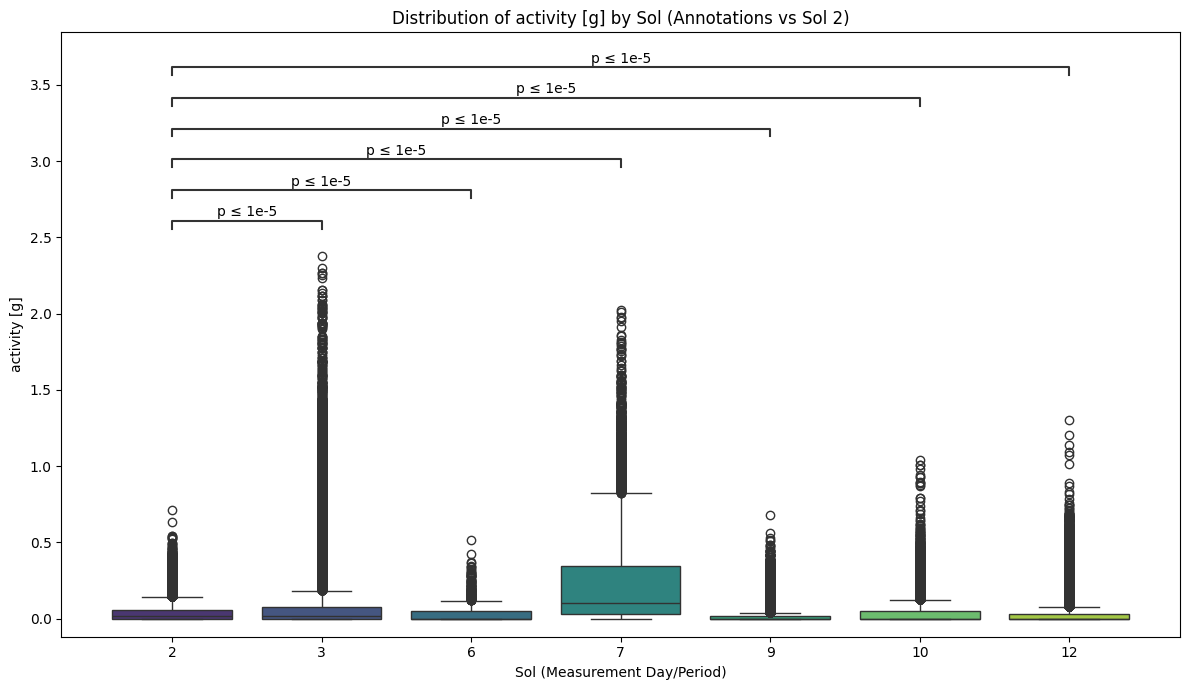



--- Visualization and Analysis for: temperature_celcius [C] ---
Overall Comparison: Kruskal-Wallis H-test
Result: H(6) = 22739.76, p < 0.001
Interpretation: Significant difference detected in the median of 'temperature_celcius [C]' across Sols.
(Refer to printed Dunn's matrix for all pairwise p-values)

Generating Annotated Box Plot for temperature_celcius [C] across Sols (vs Sol 2)...


C:\Users\User\AppData\Local\Temp\ipykernel_28344\1097530194.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=data_to_plot, x='Sol', y=variable, palette="viridis", order=plot_order)


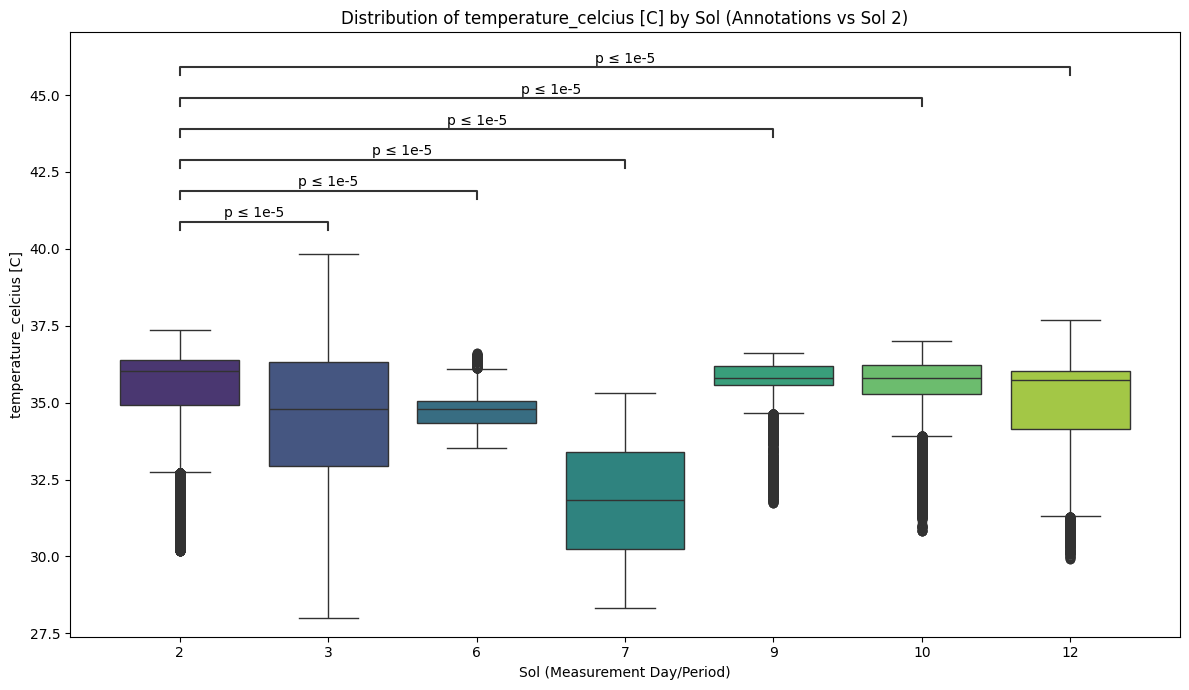



--- Visualization and Analysis for: heart_rate [bpm] ---
Overall Comparison: Kruskal-Wallis H-test
Result: H(6) = 50567.85, p < 0.001
Interpretation: Significant difference detected in the median of 'heart_rate [bpm]' across Sols.
(Refer to printed Dunn's matrix for all pairwise p-values)

Generating Annotated Box Plot for heart_rate [bpm] across Sols (vs Sol 2)...


C:\Users\User\AppData\Local\Temp\ipykernel_28344\1097530194.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=data_to_plot, x='Sol', y=variable, palette="viridis", order=plot_order)


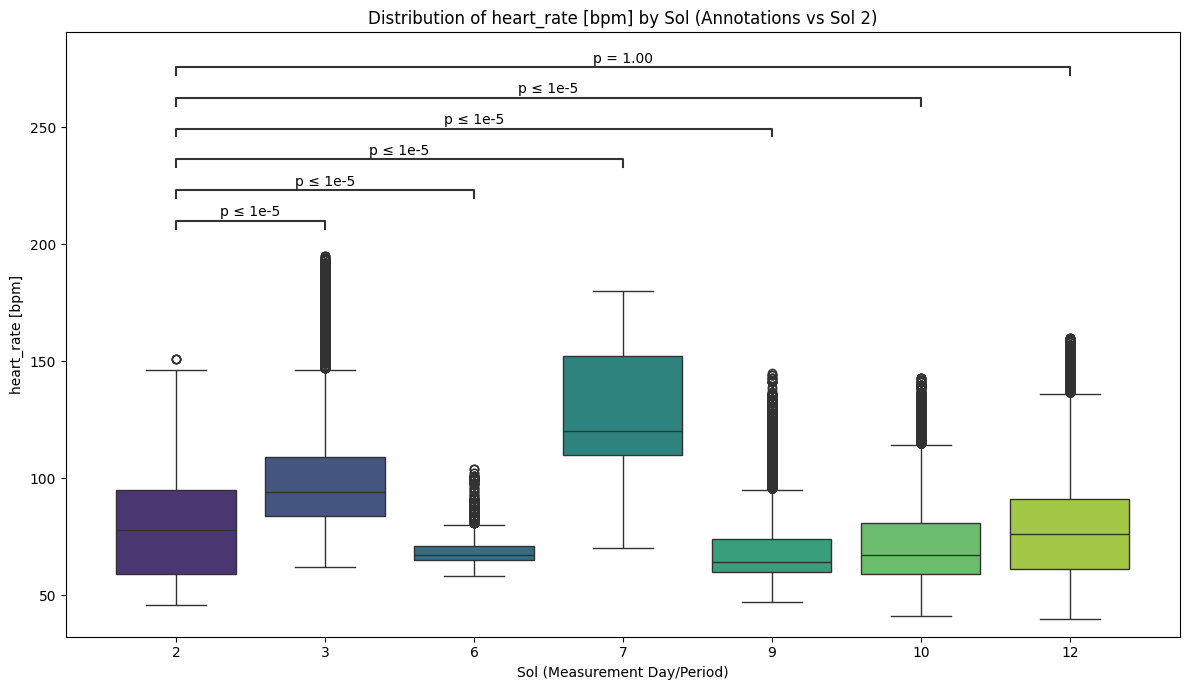



--- Visualization and Analysis for: cadence [spm] ---
Overall Comparison: Kruskal-Wallis H-test
Result: H(6) = 14061.79, p < 0.001
Interpretation: Significant difference detected in the median of 'cadence [spm]' across Sols.
(Refer to printed Dunn's matrix for all pairwise p-values)

Generating Annotated Box Plot for cadence [spm] across Sols (vs Sol 2)...


C:\Users\User\AppData\Local\Temp\ipykernel_28344\1097530194.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=data_to_plot, x='Sol', y=variable, palette="viridis", order=plot_order)


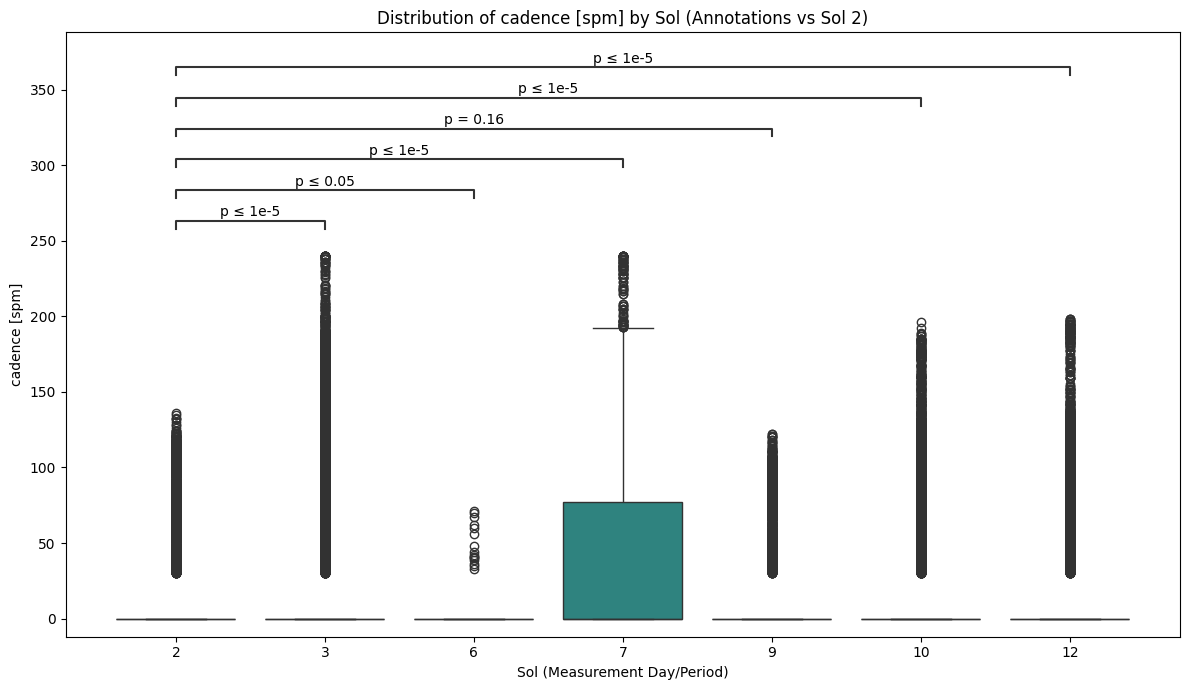


--- End of Annotated Visualizations ---


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator
import pandas as pd
import numpy as np

# Assuming df_clean is your cleaned DataFrame
# Assuming results_summary holds the Kruskal-Wallis results
# Assuming dunn_results_all holds the Dunn's test p-value matrices

print("\n--- Variable Distributions Across Sols (Box Plots with Statistical Annotations) ---")

variables_to_visualize = [var for var, res in results_summary.items() if res['p_value'] < 0.05]

# Determine the reference Sol (usually the first one numerically)
# Ensure Sols are treated as categories/strings for plotting order if needed
sols_present = sorted(df_clean['Sol'].dropna().unique())
if not sols_present:
    print("No Sol values found to determine a reference.")
else:
    reference_sol = sols_present[0]
    print(f"Using Sol {reference_sol} as the reference for pairwise annotations.")

    for variable in variables_to_visualize:

        # --- Statistical Summary (Kruskal-Wallis) ---
        print(f"\n\n--- Visualization and Analysis for: {variable} ---")
        if variable in results_summary:
            result_data = results_summary[variable]
            stat = result_data['statistic']
            p_value = result_data['p_value']
            degrees_freedom = result_data['df']
            print(f"Overall Comparison: Kruskal-Wallis H-test")
            p_value_str = f"p = {p_value:.3f}" if p_value >= 0.001 else "p < 0.001"
            print(f"Result: H({degrees_freedom}) = {stat:.2f}, {p_value_str}")
            print(f"Interpretation: Significant difference detected in the median of '{variable}' across Sols.")
            print(f"(Refer to printed Dunn's matrix for all pairwise p-values)")
        else:
            print(f"Overall statistical results for {variable} not found in summary.")

        # --- Visualization (Box Plot with Annotations) ---
        print(f"\nGenerating Annotated Box Plot for {variable} across Sols (vs Sol {reference_sol})...")

        if variable not in df_clean.columns or df_clean[variable].isnull().all():
            print(f"Cannot generate plot for {variable}: Column missing or all NaN.")
            continue

        data_to_plot = df_clean[['Sol', variable]].dropna()
        present_sols_var = sorted(data_to_plot['Sol'].unique())

        if len(present_sols_var) < 2:
             print(f"Cannot generate plot/annotations for {variable}: Fewer than two Sols with data.")
             continue

        # Define pairs for annotation: compare each Sol to the reference_sol
        pairs_to_annotate = [(reference_sol, sol) for sol in present_sols_var if sol != reference_sol]

        # Ensure Sol is treated categorically if needed (often helps with order)
        # Convert Sol to string or category if it's numeric to ensure correct plotting order
        data_to_plot['Sol'] = data_to_plot['Sol'].astype(str)
        plot_order = sorted(data_to_plot['Sol'].unique(), key=int) # Sort numerically but use as strings

        # Convert pairs to use strings if Sol was converted
        pairs_to_annotate_str = [(str(p[0]), str(p[1])) for p in pairs_to_annotate]


        plt.figure(figsize=(12, 7)) # Adjusted figure size
        ax = sns.boxplot(data=data_to_plot, x='Sol', y=variable, palette="viridis", order=plot_order)
        plt.title(f'Distribution of {variable} by Sol (Annotations vs Sol {reference_sol})')
        plt.xlabel('Sol (Measurement Day/Period)')
        plt.ylabel(f'{variable}')

        # Add annotations using statannotations
        try:
            # Retrieve p-values from the Dunn's results matrix for the selected pairs
            # Note: Dunn's matrix might use numeric indices, ensure mapping if needed
            pvalues = []
            valid_pairs_for_annotation = []
            if variable in dunn_results_all:
                dunn_matrix = dunn_results_all[variable]
                for pair in pairs_to_annotate:
                    sol1, sol2 = pair
                    # Check if both sols exist as indices/columns in the matrix
                    if sol1 in dunn_matrix.index and sol2 in dunn_matrix.columns:
                        p = dunn_matrix.loc[sol1, sol2]
                        pvalues.append(p)
                        valid_pairs_for_annotation.append((str(sol1), str(sol2))) # Use string representation
                    elif sol2 in dunn_matrix.index and sol1 in dunn_matrix.columns: # Check reverse
                         p = dunn_matrix.loc[sol2, sol1]
                         pvalues.append(p)
                         valid_pairs_for_annotation.append((str(sol1), str(sol2)))
                    # else: # Handle case where a Sol might be missing from Dunn's result (e.g., only 1 data point)
                    #     print(f"Warning: Comparison pair {pair} not found in Dunn's results for {variable}.")


            if valid_pairs_for_annotation: # Only annotate if we have valid pairs and p-values
                annotator = Annotator(ax, valid_pairs_for_annotation, data=data_to_plot, x='Sol', y=variable, order=plot_order)
                annotator.configure(test=None, text_format='simple', loc='inside', verbose=0) # Use 'simple' for p-value format
                # Provide the calculated p-values directly
                annotator.set_pvalues(pvalues)
                annotator.annotate()
            else:
                 print(f"No valid pairs found for annotation for {variable}.")

        except Exception as e:
            print(f"Could not add annotations for {variable}: {e}")


        plt.tight_layout()
        plt.show()


print("\n--- End of Annotated Visualizations ---")


--- Variable Distributions Across Sols (Box Plots with Statistical Annotations) ---
Using Sol 2 as the reference for pairwise annotations.


--- Visualization and Analysis for: breathing_rate [rpm] ---
Overall Comparison: Kruskal-Wallis H-test
Result: H(6) = 18367.14, p < 0.001
Interpretation: Significant difference detected in the median of 'breathing_rate [rpm]' across Sols.

Preparing data for breathing_rate [rpm]...


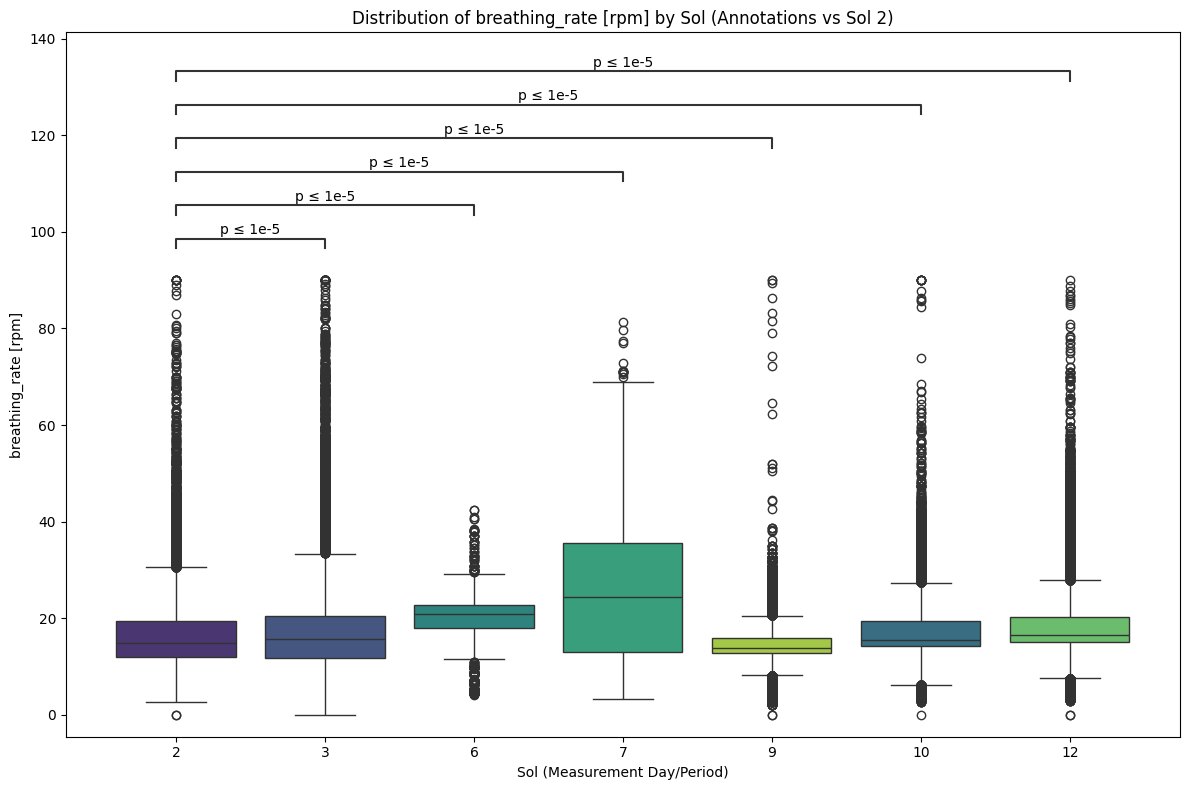



--- Visualization and Analysis for: SPO2 [%] ---
Overall Comparison: Kruskal-Wallis H-test
Result: H(6) = 77747.29, p < 0.001
Interpretation: Significant difference detected in the median of 'SPO2 [%]' across Sols.

Preparing data for SPO2 [%]...


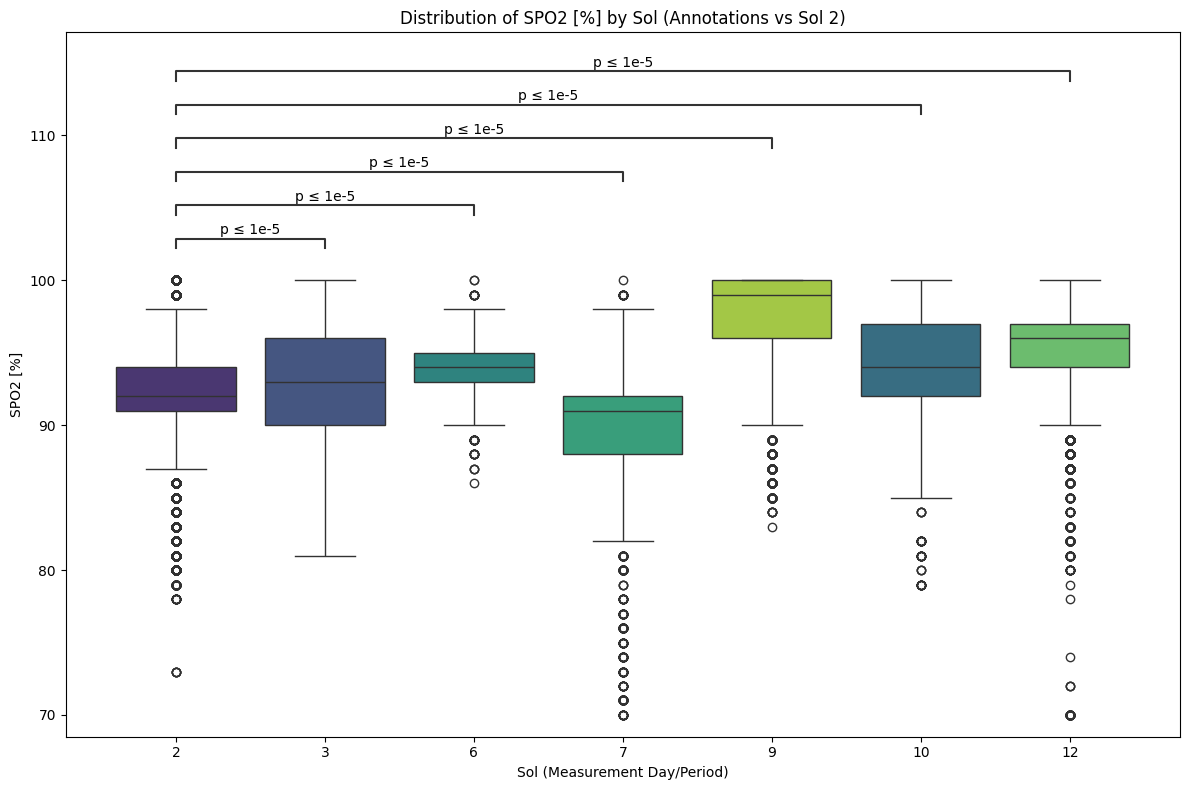



--- Visualization and Analysis for: PTT [s] ---
Overall Comparison: Kruskal-Wallis H-test
Result: H(8) = 25394.58, p < 0.001
Interpretation: Significant difference detected in the median of 'PTT [s]' across Sols.

Preparing data for PTT [s]...


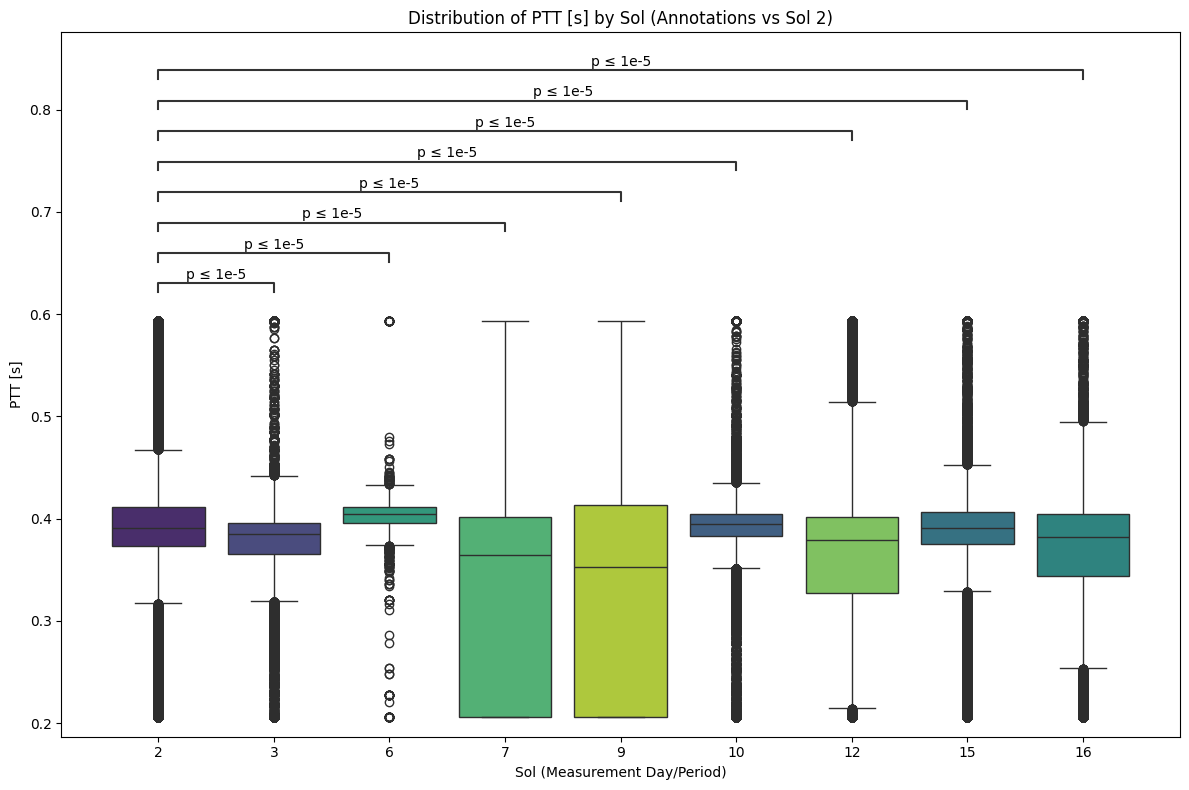



--- Visualization and Analysis for: minute_ventilation [mL/min] ---
Overall Comparison: Kruskal-Wallis H-test
Result: H(6) = 27559.42, p < 0.001
Interpretation: Significant difference detected in the median of 'minute_ventilation [mL/min]' across Sols.

Preparing data for minute_ventilation [mL/min]...


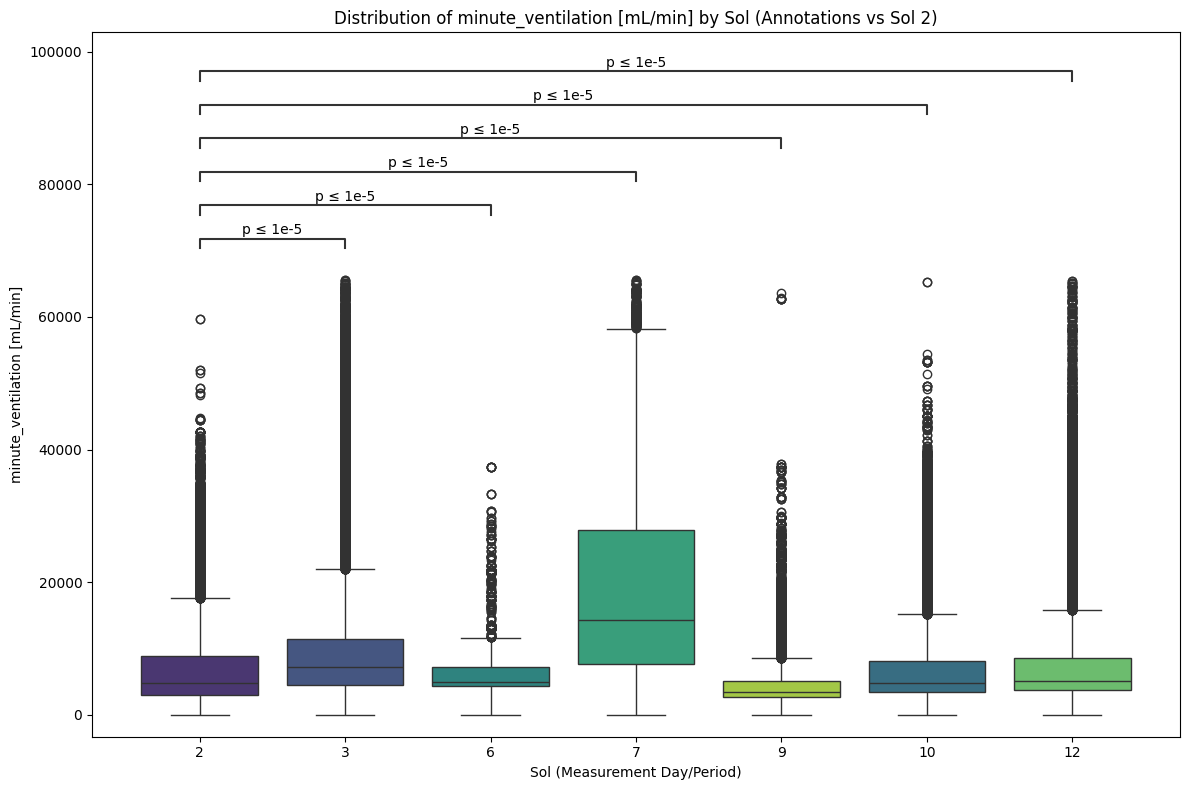



--- Visualization and Analysis for: systolic_pressure [mmHg] ---
Overall Comparison: Kruskal-Wallis H-test
Result: H(6) = 22014.00, p < 0.001
Interpretation: Significant difference detected in the median of 'systolic_pressure [mmHg]' across Sols.

Preparing data for systolic_pressure [mmHg]...


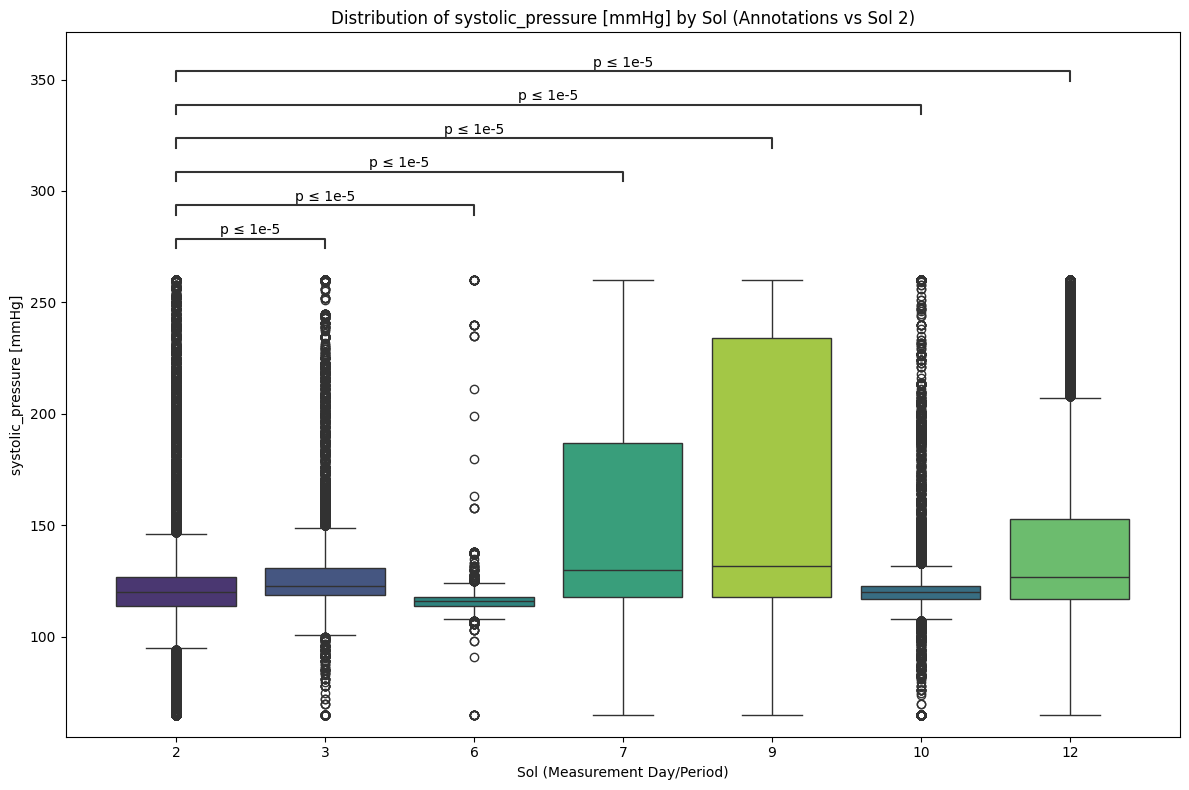



--- Visualization and Analysis for: activity [g] ---
Overall Comparison: Kruskal-Wallis H-test
Result: H(6) = 20864.97, p < 0.001
Interpretation: Significant difference detected in the median of 'activity [g]' across Sols.

Preparing data for activity [g]...


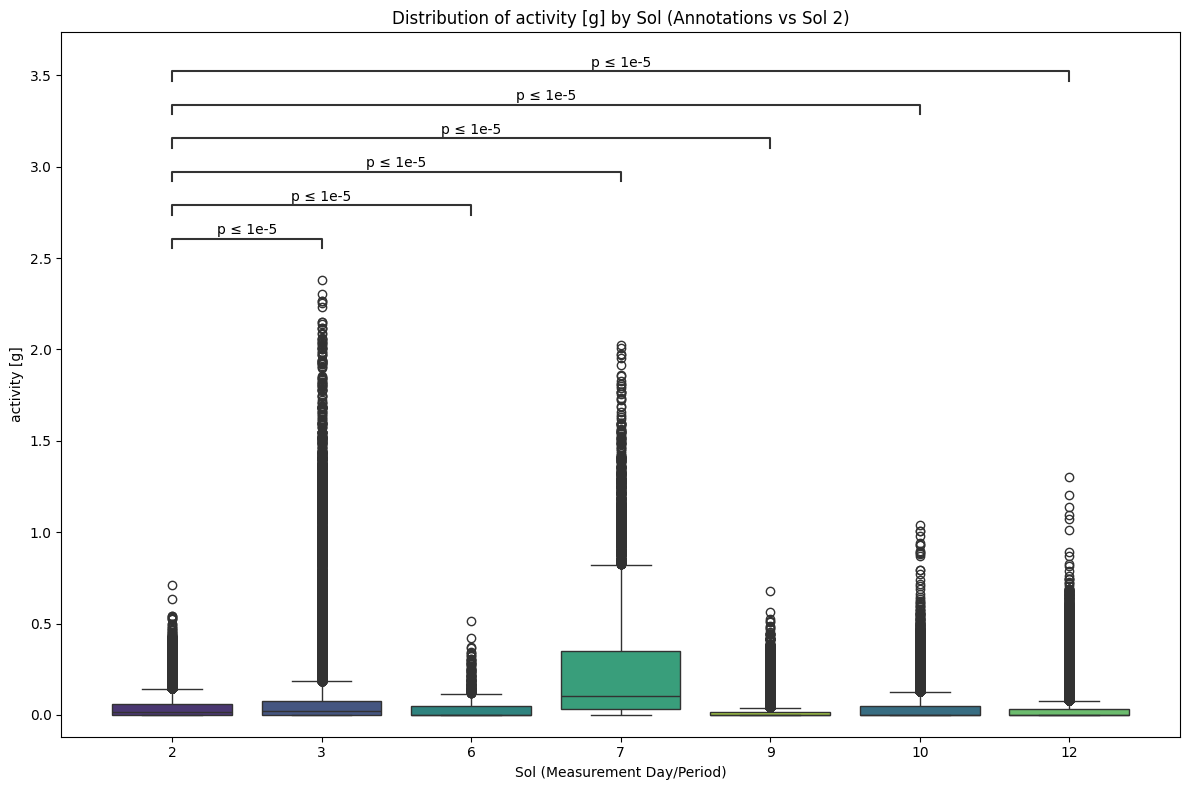



--- Visualization and Analysis for: temperature_celcius [C] ---
Overall Comparison: Kruskal-Wallis H-test
Result: H(6) = 22739.76, p < 0.001
Interpretation: Significant difference detected in the median of 'temperature_celcius [C]' across Sols.

Preparing data for temperature_celcius [C]...


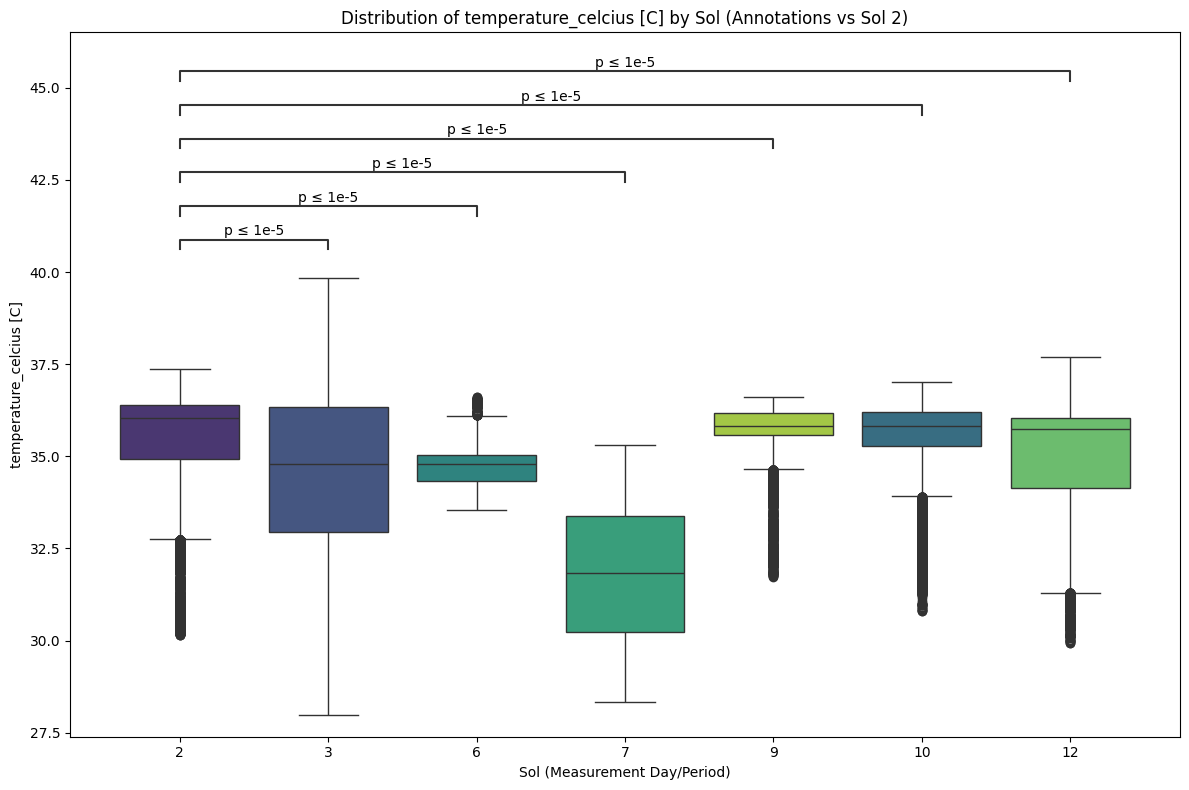



--- Visualization and Analysis for: heart_rate [bpm] ---
Overall Comparison: Kruskal-Wallis H-test
Result: H(6) = 50567.85, p < 0.001
Interpretation: Significant difference detected in the median of 'heart_rate [bpm]' across Sols.

Preparing data for heart_rate [bpm]...


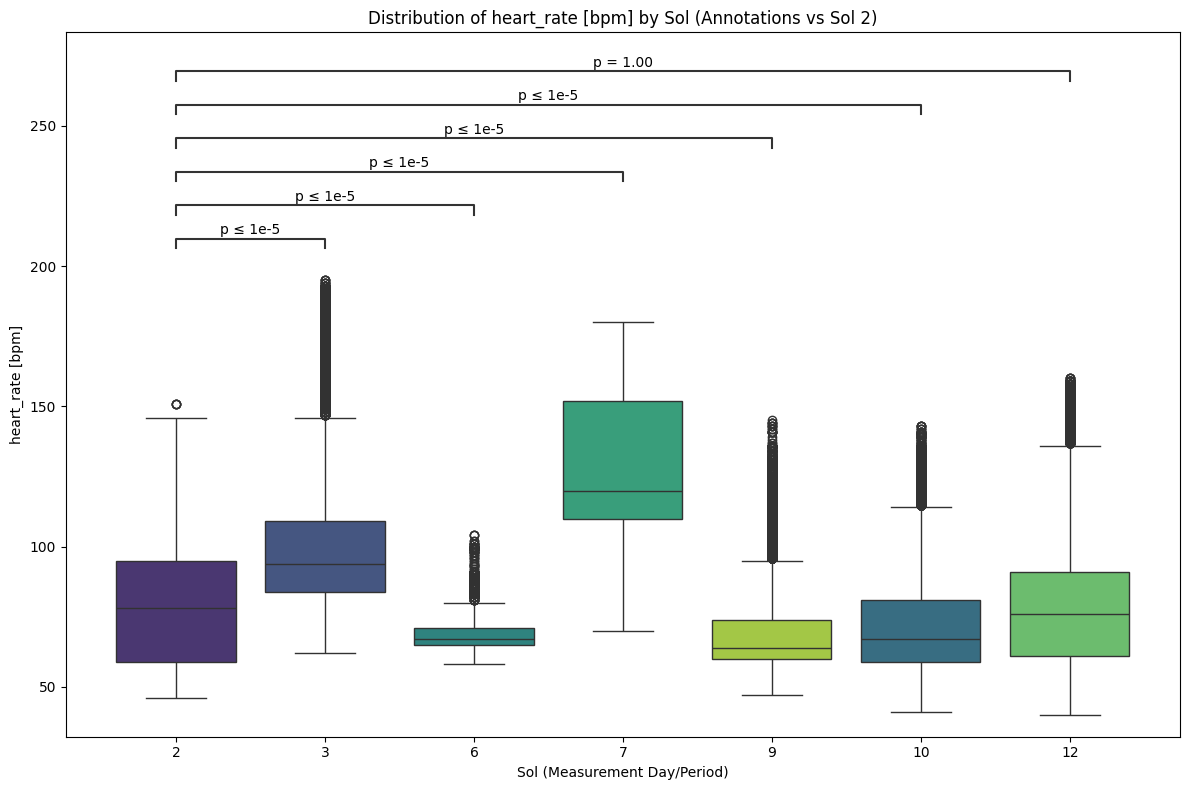



--- Visualization and Analysis for: cadence [spm] ---
Overall Comparison: Kruskal-Wallis H-test
Result: H(6) = 14061.79, p < 0.001
Interpretation: Significant difference detected in the median of 'cadence [spm]' across Sols.

Preparing data for cadence [spm]...


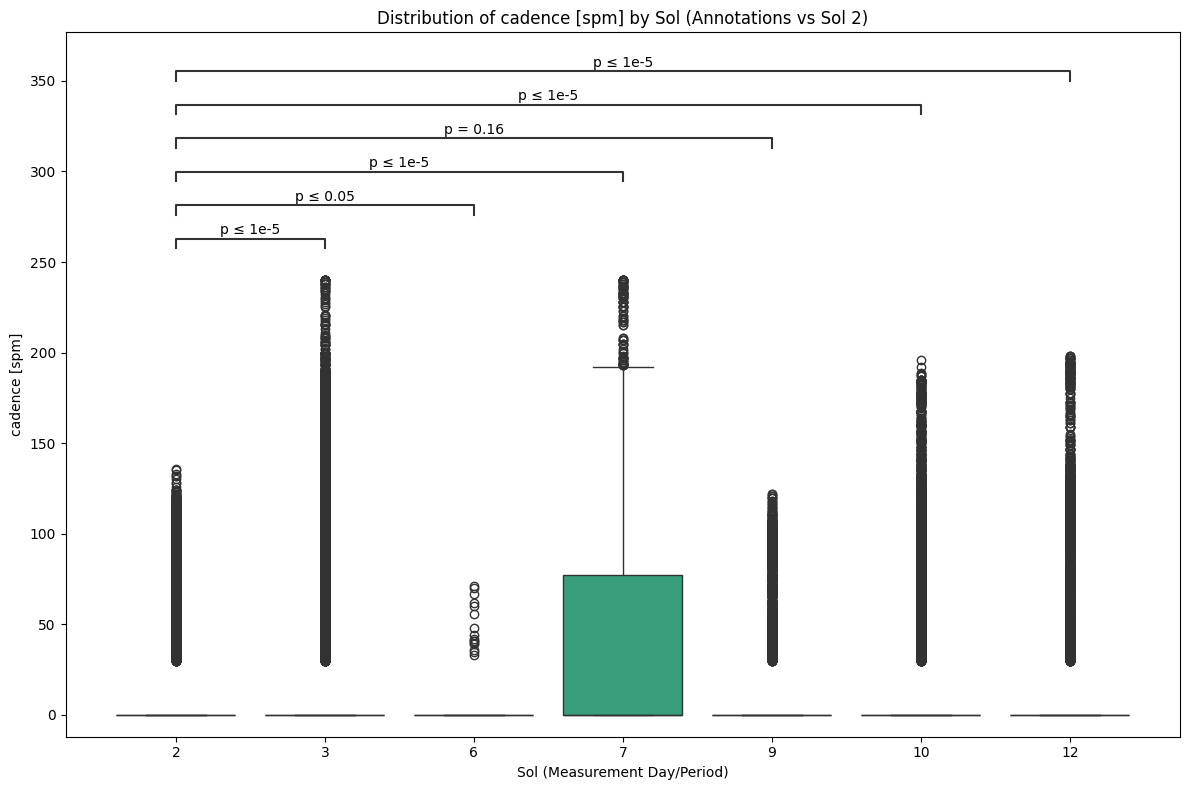


--- End of Annotated Visualizations ---


In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator
import pandas as pd
import numpy as np

# --- Visualize with Statistical Annotations (Standard Method) ---

# Assuming df_clean is your cleaned DataFrame
# Assuming results_summary holds the Kruskal-Wallis results
# Assuming dunn_results_all holds the Dunn's test p-value matrices from the previous step

print("\n--- Variable Distributions Across Sols (Box Plots with Statistical Annotations) ---")

variables_to_visualize = [var for var, res in results_summary.items() if res['p_value'] < 0.05]

# Determine the reference Sol
sols_present = sorted(df_clean['Sol'].dropna().unique())
if not sols_present:
    print("No Sol values found to determine a reference.")
else:
    reference_sol = sols_present[0]
    print(f"Using Sol {reference_sol} as the reference for pairwise annotations.")

    for variable in variables_to_visualize:

        # --- Statistical Summary (Kruskal-Wallis) ---
        print(f"\n\n--- Visualization and Analysis for: {variable} ---")
        if variable in results_summary:
            result_data = results_summary[variable]
            stat = result_data['statistic']
            p_value = result_data['p_value']
            degrees_freedom = result_data['df']
            print(f"Overall Comparison: Kruskal-Wallis H-test")
            p_value_str = f"p = {p_value:.3f}" if p_value >= 0.001 else "p < 0.001"
            print(f"Result: H({degrees_freedom}) = {stat:.2f}, {p_value_str}")
            print(f"Interpretation: Significant difference detected in the median of '{variable}' across Sols.")
        else:
            print(f"Overall statistical results for {variable} not found in summary.")

        # --- Prepare Data for Plotting ---
        print(f"\nPreparing data for {variable}...")
        if variable not in df_clean.columns or df_clean[variable].isnull().all():
            print(f"Cannot generate plot for {variable}: Column missing or all NaN.")
            continue

        data_to_plot = df_clean[['Sol', variable]].dropna()
        present_sols_var = sorted(data_to_plot['Sol'].unique())

        if len(present_sols_var) < 2:
             print(f"Cannot generate plot/annotations for {variable}: Fewer than two Sols with data.")
             continue

        # Define pairs for annotation: compare each Sol to the reference_sol
        pairs_to_annotate = [(reference_sol, sol) for sol in present_sols_var if sol != reference_sol]

        # Ensure Sol is treated categorically for plotting AND annotation consistency
        data_to_plot['Sol'] = data_to_plot['Sol'].astype(str)
        plot_order = sorted(data_to_plot['Sol'].unique(), key=int) # Sort numerically but use as strings

        # Convert pairs to use strings (matching the plot's x-axis categories)
        pairs_to_annotate_str = [(str(p[0]), str(p[1])) for p in pairs_to_annotate]

        # --- Retrieve P-values ---
        pvalues_num = [] # Store numeric p-values ONLY
        valid_pairs_for_annotation = [] # Store pairs for which p-value was found

        if variable in dunn_results_all:
            dunn_matrix = dunn_results_all[variable]
            is_numeric_index = pd.api.types.is_numeric_dtype(dunn_matrix.index.dtype)
            is_numeric_columns = pd.api.types.is_numeric_dtype(dunn_matrix.columns.dtype)

            for pair_num, pair_str in zip(pairs_to_annotate, pairs_to_annotate_str):
                sol1_num, sol2_num = pair_num
                sol1_str, sol2_str = pair_str

                p = np.nan
                lookup_keys_found = False

                if is_numeric_index and is_numeric_columns:
                    if sol1_num in dunn_matrix.index and sol2_num in dunn_matrix.columns:
                        p = dunn_matrix.loc[sol1_num, sol2_num]
                        lookup_keys_found = True
                    elif sol2_num in dunn_matrix.index and sol1_num in dunn_matrix.columns:
                        p = dunn_matrix.loc[sol2_num, sol1_num]
                        lookup_keys_found = True
                else:
                     if sol1_str in dunn_matrix.index and sol2_str in dunn_matrix.columns:
                        p = dunn_matrix.loc[sol1_str, sol2_str]
                        lookup_keys_found = True
                     elif sol2_str in dunn_matrix.index and sol1_str in dunn_matrix.columns:
                        p = dunn_matrix.loc[sol2_str, sol1_str]
                        lookup_keys_found = True

                if lookup_keys_found and not pd.isna(p):
                    pvalues_num.append(p) # Only store the numeric p-value
                    valid_pairs_for_annotation.append(pair_str)

        # --- Generate Plot ---
        plt.figure(figsize=(12, 8))
        ax = sns.boxplot(data=data_to_plot, x='Sol', y=variable, hue='Sol', palette="viridis", order=plot_order, legend=False)
        plt.title(f'Distribution of {variable} by Sol (Annotations vs Sol {reference_sol})')
        plt.xlabel('Sol (Measurement Day/Period)')
        plt.ylabel(f'{variable}')

        # --- Add Annotations ---
        if valid_pairs_for_annotation and pvalues_num: # Check if we have pairs and numeric pvalues
            try:
                annotator = Annotator(ax, valid_pairs_for_annotation, data=data_to_plot, x='Sol', y=variable, order=plot_order)
                # --- CORRECTED CONFIGURATION ---
                # Use text_format='simple'
                annotator.configure(test=None, text_format='simple', loc='inside', verbose=0)
                # Provide the numeric p-values
                annotator.set_pvalues(pvalues_num)
                # Call annotate without custom_annotations
                annotator.annotate()
                # --- END CORRECTION ---
            except Exception as e:
                print(f"ERROR: Could not add annotations for {variable}. Error: {e}")
                import traceback
                traceback.print_exc()
        else:
             print(f"Skipping annotation: No valid pairs or p-values found for {variable}.")

        plt.tight_layout()
        plt.show()


print("\n--- End of Annotated Visualizations ---")

In [40]:
import sqlite3
import pandas as pd

# Define the path to your database file. 
# If the notebook is in the same directory as the database, you can just use the filename.
# Otherwise, provide the full path.
# Define the path to your database file.
# Use the full path for reliability.
db_path = r'C:\Users\User\OneDrive\FAC\Research\Valquiria\Data\merged_data.db' 
# Using r'...' for raw string to handle backslashes correctly on Windows

# Connect to the SQLite database
try:
    conn = sqlite3.connect(db_path)
    
    # Load the 'merged_data' table into a pandas DataFrame
    df = pd.read_sql_query("SELECT * FROM merged_data", conn)
    
    print("Data loaded successfully!")
    
except sqlite3.Error as e:
    print(f"Database error: {e}")
except Exception as e:
    print(f"An error occurred: {e}")
finally:
    # Ensure the connection is closed even if errors occur
    if conn:
        conn.close()
        print("Database connection closed.")

# --- Initial Exploration ---
# Display the first 5 rows of the DataFrame
print("\nFirst 5 rows of the data:")
# Check if 'df' exists before trying to access it
if 'df' in locals():
    print(df.head())
else:
    print("DataFrame 'df' was not loaded due to previous errors.")

# Display concise summary of the DataFrame (column types, non-null counts)
print("\nDataFrame Info:")
if 'df' in locals():
    df.info()
else:
    print("DataFrame 'df' was not loaded.")

# Display descriptive statistics for numerical columns
print("\nDescriptive Statistics:")
if 'df' in locals():
    print(df.describe())
else:
    print("DataFrame 'df' was not loaded.")


Data loaded successfully!
Database connection closed.

First 5 rows of the data:
   Sol      source_file      time_raw  breathing_rate [rpm]  \
0    2  record_4494.csv  1.732544e+12                   NaN   
1    2  record_4494.csv  1.732544e+12                   NaN   
2    2  record_4494.csv  1.732544e+12                   0.0   
3    2  record_4494.csv  1.732544e+12                   NaN   
4    2  record_4494.csv  1.732544e+12                   NaN   

   minute_ventilation [mL/min]  sleep_position [NA]  activity [g]  \
0                          NaN                  NaN           NaN   
1                          NaN                  NaN           NaN   
2                          0.0                  4.0           0.0   
3                          NaN                  NaN           NaN   
4                          NaN                  NaN           NaN   

   heart_rate [bpm]  cadence [spm]  time_seconds   subject  
0               NaN            NaN  1.732544e+09  T01_Mara  
1  